# Character Language Modelling
- Deadline: 29-Oct-2025 (11:59 PM)
- Submission: https://forms.gle/CnEC9mBY5wufJQSVA

# **Assignment Instructions:**

1. Read all Instructions carefully provided for each question before beginning your work.

2. Analyze each question thoroughly and document your result, analysis, and solutions within the Google Colab notebook itself.


3. This is an individual assignment. Your work should be original. Copying from peers or online sources is strictly prohibited.

4. The use of AI tools like ChatGPT, Copilot, Gemini, LLMs or any other automated code generation tools for writing code is strictly forbidden. We will be taking your Viva for evaluating the assignment.

5. Clearly document your code with comments and explanations so that it is easy to understand your approach and thought process. It is ok to take help from some external tutorial; however cite it in your documenation otherwise it will be considered plagiarism.

6. Follow the submission guidelines strictly. Make sure your notebook is well-organized and includes all necessary code, explanations, and outputs.

7. **Once you submit your assignment, a viva will be taken to evalute you.
For the assignment submission you will have to download this colab notebook as .ipynb file, zip it and submit it via this form:https://forms.gle/CnEC9mBY5wufJQSVA**
8. The name of the zip file should follow this format: "CS779-A5-[Firstname]-[Lastname]-[Rollno].zip", where [Firstname]-[Lastname]-[Rollno] is same as your discord username. If you fail to do this, then we will not able to recover your assignment from pool of assignments as the process is automated.

9. The above form will close at the above mentioned deadline and no further solutions will be accepted either by email or by any other means.

10. If you have any doubt or get stuck in any problem, consult  TA's over Discord. It's better to take help of TAs than cheating.



#**Enter your details below:**

Full Name: Pranjali Singh

Roll No:  220796

Email:  pranjalis22@iitk.ac.in




# Character-level Causal Language Model – Pretraining (Fully Explained) [Implementation - 200 Marks]

Language models are the engines behind today’s AI text generators. Popular models including ChatGPT, Llama etc. generate text by predicting the next-token (I hope you remember tokens from previous assignments). Instead of predicting words/tokens, character-level language models learn language at the tiniest possible unit — the character. This means that, given just a few starting letters, the model can generate entire words and sentences from scratch. Think of it as teaching a computer how to spell and write creatively at the same time.

Let’s make this idea concrete. Suppose you feed the model an initial string like:

```text
The sun se
```

A word-level model might struggle if “sets” or “serpent” are rare words in its training data. But a character-level model can continue letter by letter: t, s, e, … composing “sets beyond the hills.” It does this by learning statistical patterns — which characters tend to follow which others — and by remembering longer structures, such as how sentences often end with a period or new line.

### **Why Character-Level Models Matter**

Character-level models are simple yet powerful:
- They don’t need tokenizers — just a list of characters.
- They’re great for low-resource languages or for handling creative or noisy text (like social media posts or code).
- They form the foundation for more advanced neural architectures, like decoder-only transformers used in models such as GPT.

### **Understanding the Decoder-Only Transformer**

A decoder-only transformer is the architecture at the heart of models like GPT. It builds upon three main concepts:
- Causal multi-head self-attention: Each token (or character) only attends to earlier ones, preserving the left-to-right flow of language. Additionally, multi-head attention ensures that multiple qualities of the text are attended to.
- Feed-forward layers: These refine each token’s hidden representation.
- Residual and normalization layers: They help stabilize training and maintain information across layers.

Multiple such blocks are stacked to form the full model. The output from the final layer predicts the next character using a classification head.

Visualizing this helps a lot. Here are some student-friendly visual guides to explore:
- [Decoder-only Transformer Diagram (Substack)](https://cameronrwolfe.substack.com/p/decoder-only-transformers-the-workhorse) — a clear depiction of self-attention and block stacking.
- [Transformer Architecture Illustrated (Hugging Face LLM Course)](https://huggingface.co/learn/llm-course/en/chapter1/6) — introduction with intuitive sequence flow.
- [Poloclub Transformer Explainer (Interactive)](https://poloclub.github.io/transformer-explainer/) — try out a live GPT-2 visualization to see predictions evolve in real time.

### **Bringing It All Together**

In this assignment, you’ll:

- Build your own character-level model.
- Train it to generate text character by character.
- Finetune it to:
  - Correct spellings in input text.
  - Find the correct sentiment of a sentence from IMDb sentiment challenge.

By the end, you’ll understand not just how models like GPT predict words — but how they first learned to predict letters.

---

<!-- This assignment is about training a Language Model; given compute restrictions, we will be developing a character language model, but the ideas we learn can easily be generalized and used for developing a full-fledged language model. -->

This notebook walks you through **every step** needed to pretrain a character‑level causal language model (Char‑LM) on WikiText‑103 (raw).  
It includes detailed explanations, code, logging, plots, checkpointing, and a final report.


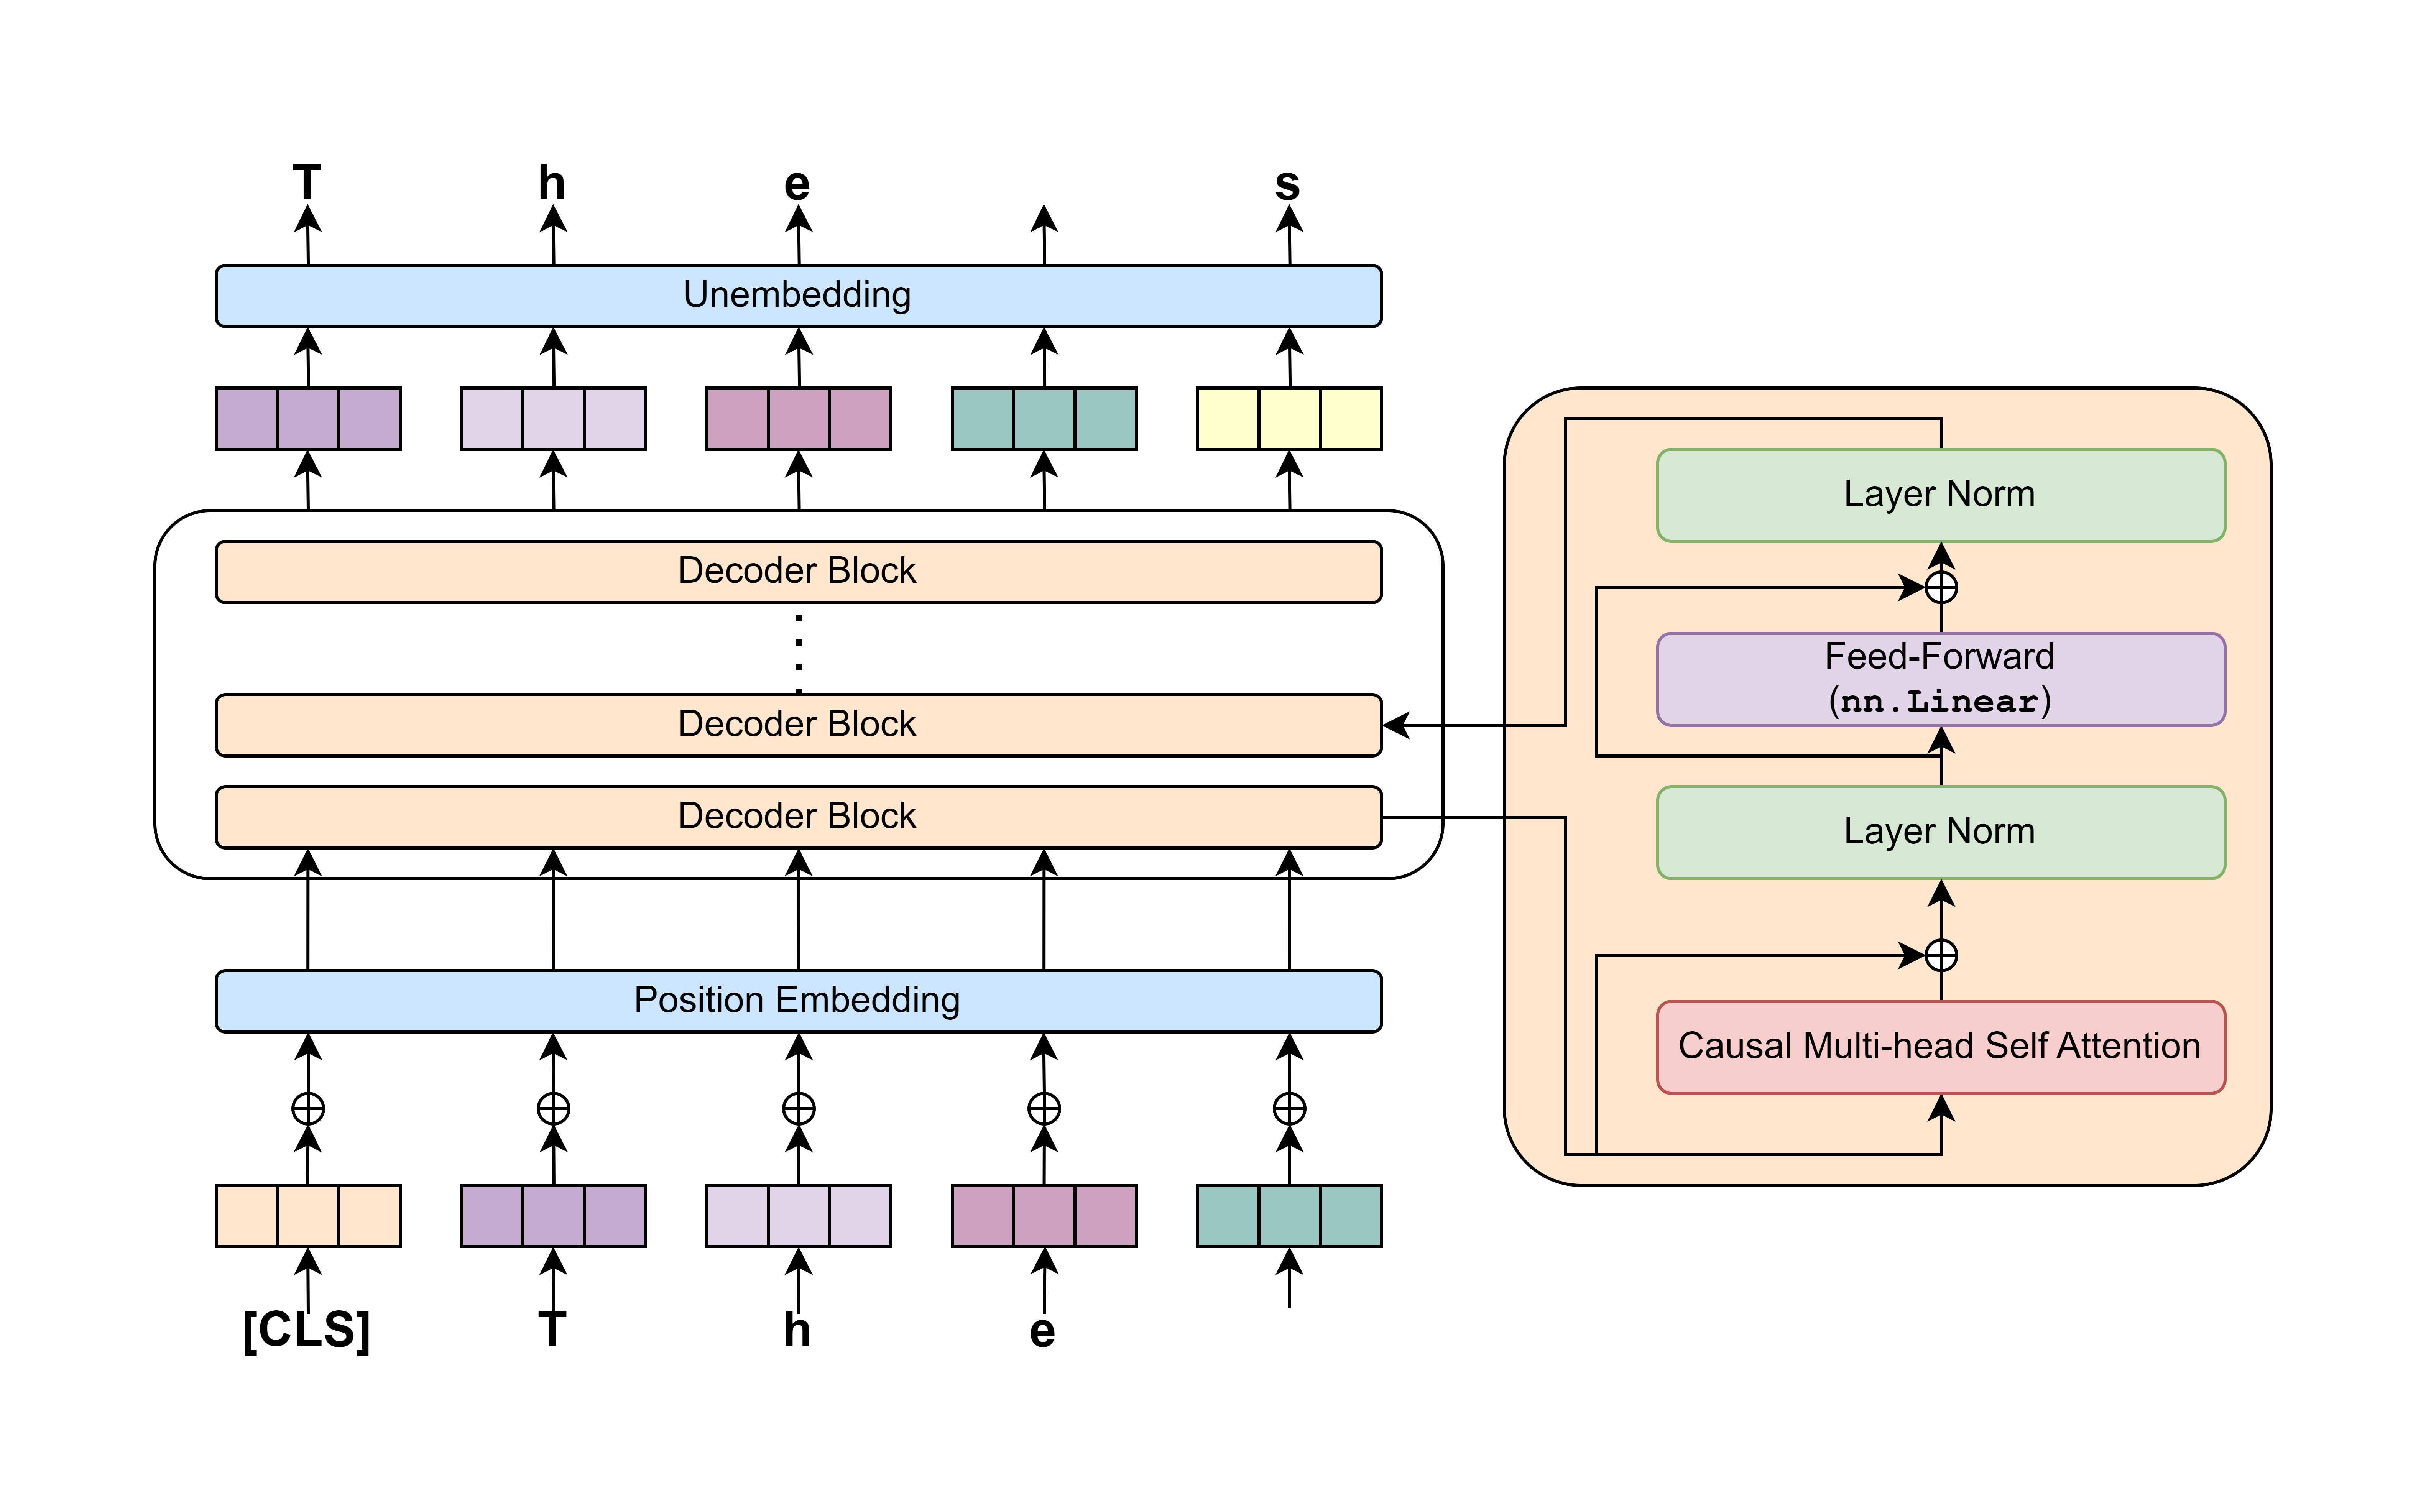


## Goals & Outputs

**Goal:** Train a char‑level LM that predicts the next character given all previous characters (causal / autoregressive).

**We will cover:**
1. Reproducible configuration & environment setup  
2. Dataset loading & sentence preparation (WikiText‑103 raw)  
3. Character vocabulary (including `<PAD>`, `<BOS>`, `<EOS>`, `<SEP>`)  
4. Tokenization at **character** level + padding/truncation strategy  
5. Model architecture in depth (embeddings → positional → Transformer layers with **causal mask** → LayerNorm → LM head)  
6. Loss, metrics, and why **perplexity** is the primary metric for language modeling  
7. Training loop with AMP, gradient clipping, AdamW, cosine LR schedule, checkpoints (best/last)  
8. Logging to CSV, saving plots (train loss, val loss, val perplexity), and a final report  
9. Practical stability/throughput tips + troubleshooting

**Artifacts produced in `save_dir/`:**
- `log_pretrain.csv`  (epoch-wise train/val metrics)  [loss and perplexity]
- `plot_pretrain_train_loss.png`, `plot_pretrain_val_loss.png`, `plot_pretrain_val_ppl.png`  
- `meta.json`  (vocab + model/training config)



## Prerequisites

Uncomment the following cell if you're in a fresh environment:


In [ ]:

# !pip install -q torch datasets tqdm matplotlib pandas



## 1) Config and Reproducibility

We define a simple dataclass `CFG` to keep all training knobs in one place.  
We also set seeds to make results repeatable (as much as possible).


In [ ]:

import os, json, math, random, string, csv
from dataclasses import dataclass
from typing import List, Dict
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

os.environ.setdefault("CUDA_VISIBLE_DEVICES", "0")
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

@dataclass
class CFG:
    save_dir: str = "checkpoints_charLM" # the directory to which the checkpoints are saved
    subset_size: int = 500_000  # Size of the training dataset
    max_len: int = 256  # Context + generation length
    batch_size: int = 64  # training batch size
    num_workers: int = 2  # number of parallel GPUs to use
    d_model: int = 512  # dimensionality of the residual stream also the output dimension of the embedding layer.
    n_heads: int = 8  # Number of heads in the multi-head self attention block
    n_layers: int = 8 # Number of decoder blocks in the model
    dropout: float = 0.1  # dropout (if required)
    epochs: int = 5 # number of training epochs
    lr: float = 1e-4  # learning rate
    weight_decay: float = 0.01  # weight decay, applicable to AdamW loss
    grad_clip: float = 1.0  # Usually required so that we can prevent the model from changing the parameters by a large value due to a noisy batch
    seed: int = 42  # A seed to control the randomness introduced by torch, numpy or any other compute library

CFG = CFG()
os.makedirs(CFG.save_dir, exist_ok=True)

def set_seed(seed: int):
    '''Setting the seed for python random, numpy and torch and torch.cuda'''
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

set_seed(CFG.seed)


Device: cuda



## 2) Data Loading and Sentence Preparation




Downloads and prepares the dataset (e.g., WikiText/OpenWebText for LM or IMDb for sentiment).  
May perform lightweight sentence splitting, filtering by length, and shuffling.

**Expected outputs:** Printed counts (e.g., number of sentences/rows). First-time runs may download data and show progress bars.


In [ ]:
from datasets import load_dataset

def load_wikitext_sentences(subset_size=None):
    '''
    Loads sentences from the "wikitext-103-raw-v1" dataset.

    Args:
      subset_size (int, optional): The number of sentences to load.
        If None, all available sentences after filtering are loaded.

    Returns:
      list: A list of cleaned and shuffled sentences.
    '''



    ds = load_dataset("Salesforce/wikitext", "wikitext-103-raw-v1", split="train")
    texts = [t.strip() for t in ds["text"] if t and len(t.strip()) > 0]
    sents = []
    for p in texts:
        p = p.replace("\n", " ")
        for s in p.split("."):
            s = s.strip()
            if 10 <= len(s) <= 300:
                sents.append(s)
    random.shuffle(sents)
    if subset_size is not None:
        sents = sents[:subset_size]
    return sents

print("Loading sentences...")
all_sents = load_wikitext_sentences(subset_size=CFG.subset_size)
print(f"Prepared sentences: {len(all_sents):,}")

Loading sentences...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

wikitext-103-raw-v1/test-00000-of-00001.(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00000-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00001-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/validation-00000-of-(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Prepared sentences: 500,000


In [ ]:
hf_rxZZkJrjfSeMLoiufPtkFSFiLrdJQyIryJy

rm: cannot remove '/root/.huggingface/token': No such file or directory



## 3) Character Vocabulary


**Task:** Implement a function that constructs a **character-level vocabulary** from a list of text sentences, including special symbols and extra characters.

#### Requirements
1. **Input:**
   - `sents`: a `List[str]` containing sentences.
   - `extra`: an optional `str` of additional characters to include in the vocabulary.

2. **Counting characters:**
   - Use Python’s `collections.Counter` to count all characters appearing in the sentences.
   - Update the counter to include the characters from `extra` even if they don’t appear in the data.

3. **Special tokens:**
   - Include the following tokens at the beginning of the vocabulary (with fixed indices):
     ```python
     SPECIAL = ['<PAD>', '<BOS>', '<EOS>', '<SEP>']
     ```
   - Assign each of these tokens a unique integer ID before adding other characters.

4. **Vocabulary construction:**
   - Build a **string-to-index mapping** (`stoi`) containing the special tokens first, then all remaining unique characters in sorted order.
   - Create the corresponding **index-to-string mapping** (`itos`) by reversing this mapping.

5. **Return values:**
   - The function `build_char_vocab` must return:
     ```python
     return stoi, itos
     ```

6. **Constants and usage:**
   - Extract the IDs of the special tokens as:
     ```python
     PAD_ID, BOS_ID, EOS_ID, SEP_ID = [stoi[t] for t in ['<PAD>', '<BOS>', '<EOS>', '<SEP>']]
     ```
   - Compute the total vocabulary size with `VOCAB_SIZE = len(stoi)`.

7. **Example behavior:**
   - If `all_sents` has more than 5000 sentences, use only the first 5000 to build the vocabulary.
   - Add common English letters, digits, punctuation, and newline characters using:
     ```python
     extra = string.ascii_letters + "0123456789 .,!?;:'\"-()[]\n"
     ```

The final code should print out the complete **vocabulary size** and produce valid lookup tables for character-level text processing.

<!-- Builds a character-level vocabulary (`stoi`/`itos`) from a small sample plus a safe extra alphabet.  
Ensures special tokens `<PAD>`, `<BOS>`, `<EOS>`, `<SEP>` are included.

**Expected outputs:** Printed vocab size. No files created yet. -->


In [ ]:
from collections import Counter
import string

def build_char_vocab(sents, extra=None, max_sen=5000):
    SPECIAL = ['<PAD>', '<BOS>', '<EOS>', '<SEP>']
    # use limited number of sentences for vocab if many
    s_sample = sents[:max_sen] if len(sents)>max_sen else sents
    cnt = Counter()
    for s in s_sample:
        cnt.update(list(s))
    # ensure extra characters included
    if extra:
        cnt.update(list(extra))
    # build stoi with specials first
    stoi = {}
    idx = 0
    for t in SPECIAL:
        stoi[t]=idx
        idx += 1
    # remaining unique chars sorted deterministically
    unique_chars =sorted([ch for ch in cnt.keys() if ch not in SPECIAL])
    for ch in unique_chars:
        if ch not in stoi:
            stoi[ch]=idx
            idx += 1
    itos = {i: s for s, i in stoi.items()}
    return stoi, itos

extra = string.ascii_letters + "0123456789 .,!?;:'\"-()[]\n"
stoi, itos =build_char_vocab(all_sents, extra=extra)
PAD_ID, BOS_ID, EOS_ID, SEP_ID = [stoi[t] for t in ['<PAD>', '<BOS>', '<EOS>', '<SEP>']]
VOCAB_SIZE =len(stoi)
print("Vocab size:", VOCAB_SIZE)


Vocab size: 274



## 4) Tokenization and Collation (Character Level)


This code defines a **character-level language modeling dataset and data pipeline** using **PyTorch**. You are required to implement functions and data structures consistent with this design.

### Required Imports
You must import these essential modules and classes before using the code:
```python
import torch
from torch.utils.data import Dataset, DataLoader
```

### Key Components and Requirements
1. **Dataset Definition**  
   Implement a subclass of `torch.utils.data.Dataset` named `CleanCLMDataset`. It should:
   - Initialize with a list of text sequences (`sents`), a character-to-index dictionary (`stoi`), and a maximum sequence length (`max_len`).
   - Return the lowercase version of each text sample in `__getitem__`.
   - Provide the number of samples in `__len__`.

2. **Collate Function (`collate_clm`)**  
   Write a custom function to batch and pad character ID sequences. It should:
   - Use special tokens from `stoi`: `<PAD>`, `<BOS>`, `<EOS>`.
   - Convert each text sample into a list of token IDs: `[BOS] + [stoi[ch]] + [EOS]`.
   - Truncate or pad each sequence to `max_len` and assemble them into a `torch.LongTensor` of shape `(batch_size, T)`.

3. **Train–Validation Split**  
   Split your list of sequences (`all_sents`) into `train_sents` and `val_sents` using proportions or heuristics depending on dataset size.

4. **DataLoader Setup**  
   Construct `torch.utils.data.DataLoader` instances for training and validation:
   - `train_loader` uses shuffling (`shuffle=True`).  
   - `val_loader` does not shuffle (`shuffle=False`).  
   - Both use the `collate_clm` function for batching and may use multiple workers (`num_workers`) and pinned memory (`pin_memory=True`).

### Summary of Learning Goals
You should demonstrate understanding of:
- How to subclass and use `torch.utils.data.Dataset`.
- How to implement a `collate_fn` for sequence padding and batching.
- How to configure `DataLoader` for training and validation workflows.

<!--

Defines Dataset and Collate functions for:  
- **Clean CLM**: `[BOS] text [EOS]` sequences  
- **Denoise**: `[BOS] noisy [SEP] clean [EOS]` sequences  
Handles padding/truncation to `max_len` and returns batch tensors.

**Expected outputs:** No immediate output. Subsequent DataLoader cells will use these. -->


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import random

class CleanCLMDataset(Dataset):
    def __init__(self, sents, stoi, max_len):
        self.sents = sents # list of text sequences
        self.stoi= stoi # character-to-index dictionary
        self.max_len =max_len # maximum sequence length

    def __len__(self):
        return len(self.sents) # number of samples

    def __getitem__(self, idx):
        s =self.sents[idx]
        # return lowercase version
        return s.lower()

def collate_clm(batch, stoi, max_len):
    PAD =stoi['<PAD>']
    BOS = stoi['<BOS>']
    EOS= stoi['<EOS>']
    ids_list =[]
    T = max_len
    for s in batch:
        seq = [BOS]+[stoi.get(ch, PAD) for ch in s]+[EOS]
        if len(seq)>T:
            seq = seq[:T]
        pad_len = T-len(seq)
        seq = seq+[PAD]*pad_len
        ids_list.append(seq)
    ids =torch.LongTensor(ids_list)
    return ids

# Train/val split
random.shuffle(all_sents)
n = len(all_sents)
val_frac = 0.02 if n>5000 else 0.1
n_val = max(1, int(n*val_frac))
val_sents= all_sents[:n_val]
train_sents = all_sents[n_val:]

train_ds =CleanCLMDataset(train_sents,stoi, CFG.max_len)
val_ds = CleanCLMDataset(val_sents, stoi, CFG.max_len)

train_loader = DataLoader(
    train_ds,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=CFG.num_workers,
    pin_memory=True,
    collate_fn=lambda b: collate_clm(b, stoi, CFG.max_len)
)

val_loader = DataLoader(
    val_ds,
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=CFG.num_workers,
    pin_memory=True,
    collate_fn=lambda b: collate_clm(b, stoi, CFG.max_len)
)


print(f"Train samples: {len(train_ds):,}, Val samples: {len(val_ds):,}")


Train samples: 490,000, Val samples: 10,000



## 5) Model Architecture — Deep Dive


The provided code defines a class `CharDecoderLM`, which uses the `nn.TransformerEncoder` architecture to model sequential dependencies between characters in text.

#### Requirements and Structure
1. **Library Imports**  
   You must import and correctly use the following libraries and modules:
   ```python
   import torch
   import torch.nn as nn
   import math
   ```
   These provide tensor operations, neural network components, and mathematical utilities required for scaling embeddings and building the Transformer architecture.

2. **Model Design (`CharDecoderLM` Class)**  
   - **Embeddings:** The model creates two embedding layers—`tok_emb` for token (character) embeddings and `pos_emb` for positional encodings. Both use dimensions defined by `d_model`.
   - **Transformer Encoder:** The core of the model is a stack of Transformer encoder layers (`nn.TransformerEncoder`), each built from `nn.TransformerEncoderLayer`. These layers handle self-attention with `n_heads` and a feedforward network with dimension `d_model * 4`.
   - **Causal Masking:** A **causal attention mask** is applied to ensure the model only attends to previous positions during training, maintaining correct autoregressive behavior.
   - **Output Projection:** The final linear layer (`self.head`) projects the hidden states back to vocabulary logits for next-character prediction.

3. **Parameter Counting Function**  
   The helper function `count_parameters` counts both total and trainable parameters in the model, useful for reporting model size and verifying correct configuration.

4. **Model Configuration and Instantiation**  
   The model is configured using the `cfg_model` dictionary which specifies hyperparameters such as `d_model`, `n_heads`, `n_layers`, `max_len`, and `dropout`, and is initialized with a defined `VOCAB_SIZE` and moved to the available computation device.

5. **Expected Output**  
   When printing parameter counts, students should report both total and trainable parameters in millions for clarity.

#### Key Reminder
Ensure that:
- All required **imports** are at the top of your file.
- The **masking logic** uses `torch.triu()` and `float('-inf')` correctly to prevent information leakage from future tokens.
- The model is constructed and executed without errors using valid tensor shapes.

If you provide these components correctly, your model will form a functional **character-level Transformer decoder** suitable for autoregressive language modeling.

<!-- Defines the **CharDecoderLM**: token + positional embeddings → Transformer encoder stack → layer norm → LM head.  
Applies a causal mask so each position predicts the next character.

**Expected outputs:** No output now. Later cells will instantiate and print parameter counts. -->


In [ ]:
import torch.nn as nn
import math

class CharDecoderLM(nn.Module):
    def __init__(self, vocab_size, d_model=512, n_heads=8, n_layers=8, max_len=256, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.tok_emb = nn.Embedding(vocab_size, d_model) # token and positional embeddings
        self.pos_emb = nn.Embedding(max_len, d_model)
        self.dropout = nn.Dropout(dropout) # dropout for regularization
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=d_model*4, dropout=dropout, activation='gelu', batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)
        self._init_weights()
        self.max_len = max_len

    def _init_weights(self):
        nn.init.normal_(self.tok_emb.weight, mean=0.0, std=0.02) #  embeddings and head with normal distribution
        nn.init.normal_(self.pos_emb.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.head.weight, mean=0.0, std=0.02)
        for p in self.parameters():
            if p.dim()>1:
                nn.init.xavier_uniform_(p, gain=1.0)

    def _causal_mask(self, T, device): # upper‑triangular mask to block attention to future tokens
        mask = torch.triu(torch.ones(T, T, dtype=torch.bool, device=device), diagonal=1)
        return mask

    def forward(self, ids):
        B, T = ids.size()
        device = ids.device
        tok = self.tok_emb(ids)
        pos_ids = torch.arange(T, device=device).unsqueeze(0).expand(B, T)
        pos = self.pos_emb(pos_ids)
        x = (tok+pos) * math.sqrt(self.d_model)
        x = self.dropout(x)
        mask = self._causal_mask(T, device=device)
        x = self.transformer(x, mask=mask)
        x=self.ln_f(x) # final norm and projection
        logits = self.head(x)
        return logits

def count_parameters(model):
    total=sum(p.numel() for p in model.parameters())
    trainable=sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

cfg_model = {"d_model":CFG.d_model, "n_heads": CFG.n_heads,"n_layers":CFG.n_layers, "max_len": CFG.max_len,"dropout":CFG.dropout}
model = CharDecoderLM(VOCAB_SIZE, **cfg_model).to(device)
tot, trainable = count_parameters(model)
print(f"Parameters: total={tot/1e6:.3f}M, trainable={trainable/1e6:.3f}M")

Parameters: total=25.632M, trainable=25.632M



## 6) Loss and Metrics


The cross-entropy loss formula used in the code snippet for next-token prediction in language modeling is:

$$
\text{Loss} = -\sum_{i=1}^{|V|} y_i \log(\hat{y}_i)
$$

where:
- $|V|$ is the vocabulary size,
- $y_i$ is the true probability distribution (one-hot encoded, so only the correct token is 1, others are 0),
- $\hat{y}_i$ is the predicted probability for token $i$.

For a single target token $y_t$, this simplifies to:

$$
\text{Loss} = -\log(\hat{y}_{y_t})
$$

where $\hat{y}_{y_t}$ is the predicted probability for the correct next token at position $t$.

--

This code defines two helper functions essential for evaluating language models in natural language processing tasks.

The first function, `next_token_loss_full`, computes the **cross-entropy loss** for next-token prediction, which is a standard training objective in language modeling. It uses the `nn.CrossEntropyLoss` class from **PyTorch’s** `torch.nn` module, specifying `ignore_index=pad_id` to exclude padding tokens from contributing to the loss. The function shifts the logits and target token IDs by one position to ensure the model predicts the next token at each time step. Both tensors are reshaped with `.contiguous().view(-1, …)` to match the expected input shape for `CrossEntropyLoss`.

---

The formula for perplexity in language modeling, based on the cross-entropy loss, is:

$$
\text{Perplexity} = \exp(\text{Loss})
$$

where "Loss" is the average cross-entropy loss per token over the sequence. This formula directly matches the implementation in your code, where the loss value is exponentiated to obtain the perplexity.

---

The second function, `perplexity_from_loss`, converts a scalar loss value into **perplexity**, a common evaluation metric that measures how well a model predicts a sample. It uses the `math.exp()` function from Python’s **math** library and guards against overflow with a `try/except` block, returning infinity (`float('inf')`) if the exponential cannot be computed.

**Required imports:**
```python
import math
import torch.nn as nn
```
Be sure to import both before using these functions, as they rely on PyTorch’s neural network tools (`nn`) and the standard library `math` module.

<!-- Implements **next-token cross-entropy** for causal language modeling, ignoring `<PAD>`.  
Used during pretraining to minimize negative log-likelihood over all tokens.

**Expected outputs:** No output yet. Loss will appear in training logs. -->


In [ ]:
def next_token_loss_full(logits, ids, pad_id):
    B, T, V = logits.shape # shift
    logits_next = logits[:, :-1, :].contiguous()    # (B, T-1, V)
    targets = ids[:, 1:].contiguous()               # (B, T-1)
    loss_f = nn.CrossEntropyLoss(ignore_index=pad_id, reduction='mean')
    loss = loss_f(logits_next.view(-1, V), targets.view(-1))
    return loss

def perplexity_from_loss(loss):
    try:
        ppl = math.exp(loss)
    except OverflowError:
        ppl = float('inf')
    return ppl


## 7) Optimizer, Scheduler, AMP, Gradient Clipping


This code segment sets up the **optimizer**, **learning rate scheduler**, and **training logger** for a PyTorch-based NLP model pretraining pipeline. It uses several components from the `torch` library to manage optimization, mixed precision training, and logging.

#### Key Components

1. **Optimizer Setup**
   - The line
     ```python
     optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
     ```
     initializes the **AdamW optimizer** (from `torch.optim`) with parameters of the model. You should ensure that both `torch` and `torch.optim` are imported, and that `CFG` contains defined hyperparameters for `lr` (learning rate) and `weight_decay`.

2. **Gradient Scaling for Mixed Precision**
   - Mixed precision training is enabled through:
     ```python
     scaler = torch.amp.GradScaler('cuda', enabled=(device == 'cuda'))
     ```
     which comes from the `torch.amp` module. It helps maintain numerical stability and efficiency when training on CUDA-enabled GPUs.

3. **Learning Rate Scheduler**
   - The total number of training steps is computed, and the **CosineAnnealingLR** scheduler is initialized as:
     ```python
     steps_total = max(1, CFG.epochs * len(train_loader))
     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=steps_total)
     ```
     This scheduler gradually reduces the learning rate following a **cosine function** over the total number of steps, which helps improve convergence.

4. **Logging Training Progress**
   - CSV logging is configured with:
     ```python
     log_csv = os.path.join(CFG.save_dir, "log_pretrain.csv")
     with open(log_csv, "w", newline="") as f:
         csv.writer(f).writerow(["epoch","train_loss","val_loss","val_perplexity","lr_last"])
     ```
     This ensures that during training, metrics such as losses and learning rates are recorded for later analysis. The `os` and `csv` modules must be imported for this to work.

5. **Model Checkpoint Management**
   - Paths for saving the best and last model checkpoints are set:
     ```python
     best_val_ppl = float("inf")
     best_path = os.path.join(CFG.save_dir, "best_pretrain.pt")
     last_path = os.path.join(CFG.save_dir, "last_pretrain.pt")
     ```
     These will later be used to store models with the lowest validation perplexity and the final epoch’s weights.

#### Required Imports
Before running this code block, the following imports are **required**:
```python
import torch
import torch.optim
import torch.amp
import os
import csv
```

Confirm that `CFG`, `model`, `train_loader`, and `device` are defined in the training script prior to running this section.

<!-- Configures the runtime device.  
Seeds are set for reproducibility if present. -->




In [ ]:
import torch.optim as optim
from torch import amp
import os, csv

optimizer = optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)

steps_total = max(1, CFG.epochs * max(1, len(train_loader)))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=steps_total)

scaler = amp.GradScaler(device="cuda", enabled=(device == 'cuda'))

log_csv = os.path.join(CFG.save_dir, "log_pretrain.csv")
with open(log_csv, "w", newline="") as f:
    csv.writer(f).writerow(["epoch","train_loss","val_loss","val_perplexity","lr_last"])

best_val_ppl = float("inf")
best_path = os.path.join(CFG.save_dir, "best_pretrain.pt")
last_path = os.path.join(CFG.save_dir, "last_pretrain.pt")


## 8) Training and Validation Loops


This code snippet implements a **complete epoch loop** for training and validating a neural language model in **PyTorch** using **automatic mixed precision (AMP)**, gradient clipping, and a **learning rate scheduler**. You are expected to reproduce this functionality correctly as part of the assignment.

#### Key Requirements and Responsibilities
1. **Iterative Epoch Loop** — The code runs for `CFG.epochs` iterations. Each epoch includes both a **training** and **validation** phase.
2. **Training Phase** (`model.train()`):
   - The model is set to training mode using `model.train()`.
   - Mini-batches of tokenized inputs (`ids`) are drawn from `train_loader`.
   - Inside the loop, automatic mixed precision is applied using `torch.amp.autocast('cuda', enabled=(device == 'cuda'))` for efficient GPU computation.
   - The model’s forward pass produces `logits`, and a **next-token prediction loss** is computed using `next_token_loss_full(logits, ids, PAD_ID)`.
   - The backward pass is handled through a **gradient scaler** (`torch.cuda.amp.GradScaler`) to support mixed precision.
   - Gradients are clipped using `torch.nn.utils.clip_grad_norm_()` to prevent exploding gradients.
   - Optimizer and scheduler are updated each step, and running loss is recorded for progress display with `tqdm`.
3. **Validation Phase** (`model.eval()`):
   - The model is set to evaluation mode (`torch.no_grad()` disables gradient tracking).
   - The same loss function is used on `val_loader` batches to compute the average validation loss.
   - The model’s **perplexity** is computed via `perplexity_from_loss(val_loss)`.
4. **Logging and Checkpointing:**
   - Metrics are appended to a CSV log file (`log_csv`).
   - The model is saved (`torch.save`) whenever validation perplexity improves, and the best and last model checkpoints are stored.

#### Required Imports
Ensure the following key libraries and modules are properly imported:
```python
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import csv
```
Additionally, import all user-defined utilities referenced here:
- `next_token_loss_full()` – custom token-level loss function.
- `perplexity_from_loss()` – converts average loss to perplexity.
- `CFG` – configuration object containing hyperparameters (`epochs`, `grad_clip`, etc.).

***
**Instructor’s Note:** When re-creating this block, you must demonstrate correct usage of **autocast**, **GradScaler**, and **gradient clipping** to manage numerical stability during mixed-precision training on CUDA devices.

<!-- Train and validate the model. -->

In [ ]:
from tqdm.auto import tqdm

for epoch in range(1, CFG.epochs + 1):
    model.train()
    running_loss = 0.0
    steps = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch} train", leave=False)
    for ids in pbar:
        ids = ids.to(device)
        optimizer.zero_grad()
        with torch.autocast(device_type='cuda' if device=='cuda' else 'cpu', enabled=(device=='cuda')):
            logits = model(ids)  # (B, T, V)
            loss = next_token_loss_full(logits, ids, PAD_ID)
        scaler.scale(loss).backward()
        # gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.grad_clip)
        scaler.step(optimizer)
        scaler.update()
        # scheduler step per step (CosineAnnealing expects stepping by epoch or step)
        try:
            scheduler.step()
        except Exception:
            pass

        running_loss+=loss.item()
        steps+=1
        pbar.set_postfix({"loss": running_loss/steps, "lr": optimizer.param_groups[0]['lr']})

    train_loss = running_loss / max(1, steps)

    # Validation
    model.eval()
    val_running = 0.0
    val_steps = 0
    with torch.no_grad():
        for ids in tqdm(val_loader, desc=f"Epoch {epoch} val", leave=False):
            ids = ids.to(device)
            with torch.autocast(device_type='cuda' if device=='cuda' else 'cpu', enabled=(device=='cuda')):
                logits = model(ids)
                loss = next_token_loss_full(logits, ids, PAD_ID)
            val_running += loss.item()
            val_steps += 1
    val_loss = val_running / max(1, val_steps)
    val_ppl = perplexity_from_loss(val_loss)

    # Logging to CSV
    lr_last = optimizer.param_groups[0]['lr']
    with open(log_csv, "a", newline="") as f:
        csv.writer(f).writerow([epoch, train_loss, val_loss, val_ppl, lr_last])

    # Save checkpoints
    torch.save({"epoch": epoch, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict()}, last_path)
    if val_ppl < best_val_ppl:
        best_val_ppl = val_ppl
        torch.save({"epoch": epoch, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict()}, best_path)

    print(f"Epoch {epoch} | train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | val_ppl: {val_ppl:.3f} | lr: {lr_last:.2e}")


Epoch 1 train:   0%|          | 0/7657 [00:00<?, ?it/s]

Epoch 1 val:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1 | train_loss: 1.5881 | val_loss: 1.3040 | val_ppl: 3.684 | lr: 9.05e-05


Epoch 2 train:   0%|          | 0/7657 [00:00<?, ?it/s]

Epoch 2 val:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2 | train_loss: 1.3051 | val_loss: 1.2176 | val_ppl: 3.379 | lr: 6.55e-05


Epoch 3 train:   0%|          | 0/7657 [00:00<?, ?it/s]

Epoch 3 val:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3 | train_loss: 1.2412 | val_loss: 1.1789 | val_ppl: 3.251 | lr: 3.45e-05


Epoch 4 train:   0%|          | 0/7657 [00:00<?, ?it/s]

Epoch 4 val:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4 | train_loss: 1.2099 | val_loss: 1.1599 | val_ppl: 3.190 | lr: 9.55e-06


Epoch 5 train:   0%|          | 0/7657 [00:00<?, ?it/s]

Epoch 5 val:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5 | train_loss: 1.1971 | val_loss: 1.1564 | val_ppl: 3.178 | lr: 0.00e+00



## 9) Plots: Train Loss, Val Loss, Val Perplexity


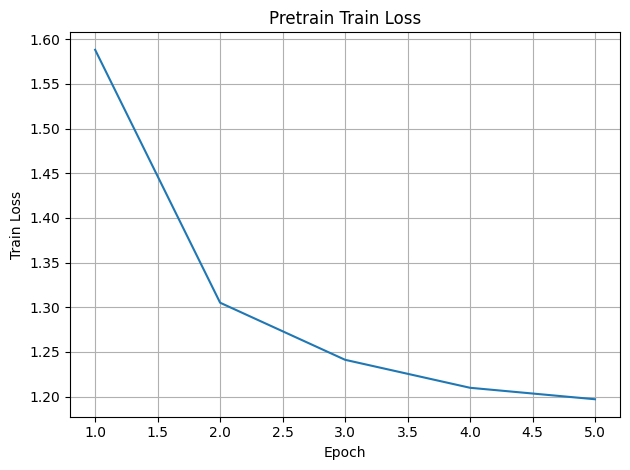

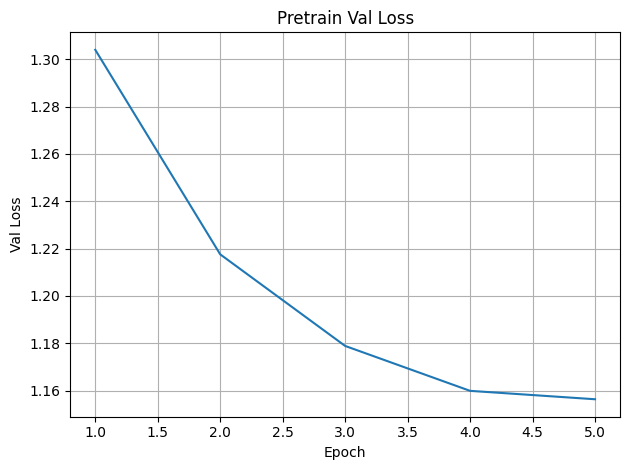

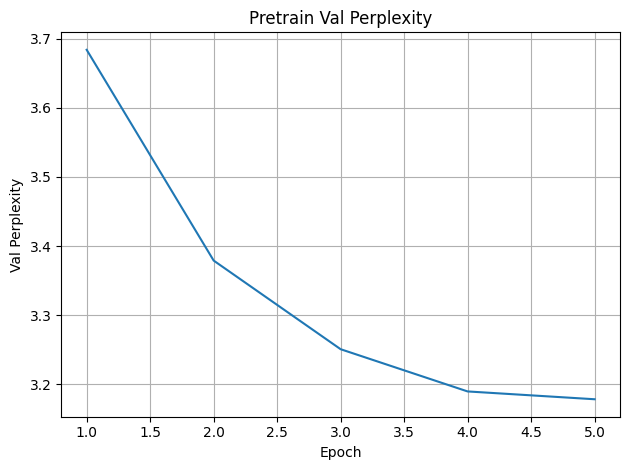

Saved plots in: checkpoints_charLM


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os

df = pd.read_csv(log_csv)

# Train Loss
plt.figure()
plt.plot(df["epoch"], df["train_loss"])
plt.xlabel("Epoch"); plt.ylabel("Train Loss"); plt.title("Pretrain Train Loss")
plt.grid(True); plt.tight_layout()
plt.savefig(os.path.join(CFG.save_dir, "plot_pretrain_train_loss.png"), dpi=160)
plt.show()

# Val Loss
plt.figure()
plt.plot(df["epoch"], df["val_loss"])
plt.xlabel("Epoch"); plt.ylabel("Val Loss"); plt.title("Pretrain Val Loss")
plt.grid(True); plt.tight_layout()
plt.savefig(os.path.join(CFG.save_dir, "plot_pretrain_val_loss.png"), dpi=160)
plt.show()

# Val Perplexity
plt.figure()
plt.plot(df["epoch"], df["val_perplexity"])
plt.xlabel("Epoch"); plt.ylabel("Val Perplexity"); plt.title("Pretrain Val Perplexity")
plt.grid(True); plt.tight_layout()
plt.savefig(os.path.join(CFG.save_dir, "plot_pretrain_val_ppl.png"), dpi=160)
plt.show()

print("Saved plots in:", CFG.save_dir)


## 10) Save `meta.json`




Serializes **meta.json**: vocabulary, inverse vocab, and run configuration.  
Enables consistent reload for downstream tasks.

**Expected outputs:** A `meta.json` file under `save_dir`.


In [ ]:

meta = {
    "stoi": stoi,
    "itos": {int(k): v for k, v in {i:s for s,i in stoi.items()}.items()},  # invert stable
    "cfg": {
        **cfg_model,
        "save_dir": CFG.save_dir,
        "subset_size": len(all_sents),
        "epochs": CFG.epochs,
        "lr": CFG.lr,
        "weight_decay": CFG.weight_decay,
        "grad_clip": CFG.grad_clip,
        "batch_size": CFG.batch_size,
        "num_workers": CFG.num_workers,
        "max_len": CFG.max_len,
        "seed": CFG.seed
    }
}
with open(os.path.join(CFG.save_dir, "meta.json"), "w") as f:
    json.dump(meta, f)
print("Saved meta.json")



Saved meta.json



## 11) Final Report


Just print results like val_preplexity of best model ,Sentences used to for val.Last epoch val_perplexity.
Also store log_pretrain.csv in format of epoch,train_loss,val_preplexity.

In [ ]:

import pandas as pd
df = pd.read_csv(log_csv)
last_row = df.iloc[-1]
print("\n=== Pretrain Report ===")
print(f"Sentences used         : {len(all_sents)}")
print(f"Epochs                 : {CFG.epochs}")
print(f"Best val perplexity    : {df['val_perplexity'].min():.3f} (epoch {df['val_perplexity'].idxmin()+1})")
print(f"Last epoch val perplex.: {last_row['val_perplexity']:.3f}")
print("Saved:", os.path.join(CFG.save_dir, "best_pretrain.pt"))
print("Saved:", os.path.join(CFG.save_dir, "last_pretrain.pt"))
print("Logs :", os.path.join(CFG.save_dir, "log_pretrain.csv"))



=== Pretrain Report ===
Sentences used         : 500000
Epochs                 : 5
Best val perplexity    : 3.178 (epoch 5)
Last epoch val perplex.: 3.178
Saved: checkpoints_charLM/best_pretrain.pt
Saved: checkpoints_charLM/last_pretrain.pt
Logs : checkpoints_charLM/log_pretrain.csv



## 12) Evaluation Guidance



- **Validation perplexity** is the primary metric. Lower is better.  
- Char‑level models typically show higher loss/perplexity than word‑level. Compare **relative** improvements across runs.  
- Track curves: healthy training → train loss goes down, val loss tends to flatten or decrease moderately.



# Two Downstream Tasks for Char-Level LM
We extend the original pretraining notebook with **two practical downstream tasks** built on the same character-level Transformer encoder:

1. **Spell-Correction (Denoising)** – target-only loss, CER evaluation, greedy decoding.
2. **IMDb Sentiment Classification** – classifier head, Accuracy/F1, ROC & AUROC.

Each section is fully runnable and includes clear explanations and metrics.


## Spell-Correction (Denoising) task
In the spell-correction (Denoising) task, you’ll explore how a **character-level language model** (you trained above) can learn to *"fix spelling mistakes"* by training it to transform noisy text into its correct form. You’ll start with a pretrained model and finetune it using pairs of text examples that show how a noisy input maps to its clean, denoised version.

Each example is formatted as:

```
<BOS> noisy text <SEP> denoised text <EOS>
```

Here, `<BOS>` marks the beginning of the sequence, `<SEP>` separates the noisy input from the target output, and `<EOS>` signals the end of the example.

For example:

```
<BOS> teh quik borwn fix <SEP> the quick brown fox <EOS>
```

During finetuning, the model learns to generate the corrected text after the `<SEP>` token, effectively modeling how characters should be changed, deleted, or inserted to fix common errors. This activity helps you understand how sequence-to-sequence learning works at the character level and deepens your intuition about noise-robust language modeling and text generation.




## Metrics

**Cross-Entropy (CE)**: token-level negative log-likelihood; lower is better.  
**Perplexity (PPL)**: $\exp(\text{CE})$. Measures how "surprised" the model is; lower is better.

**Levenshtein Distance**: minimal edits (insert/delete/substitute) to turn one string into another.  
**Character Error Rate (CER)**:  
$$ \text{CER} = \frac{\text{Levenshtein}(\text{prediction},\ \text{gold})}{\max(1, |\text{gold}|)} $$
Interprets spelling quality: 0.10 means ~10% of characters must change on average.

**Accuracy**: fraction of correct predictions.  
**Precision/Recall**: precision = TP/(TP+FP), recall = TP/(TP+FN).  
**F1**: harmonic mean of precision & recall.

**Receiver-operating characteristic (ROC) curve**: plots **TPR** vs **FPR** as threshold varies.  
**AUROC**: area under ROC; 0.5≈random, 1.0=perfect.



## 1) Environment & Quick Setup
This cell installs any missing libraries and configures device + seeds for reproducibility.


In [ ]:

# Optional installs (uncomment if needed)
# !pip install -q datasets tqdm matplotlib pandas

import os, random, json, math
import numpy as np
import torch

# Device + seeds
os.environ.setdefault("CUDA_VISIBLE_DEVICES", "0")
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


Device: cuda



## 2) Shared Utilities (implement all these)

### **Code Requirements and Description**

In this part of the assignment, you are required to implement a **character-level noise augmentation and evaluation module** for text data. The provided code defines helper functions to **add realistic noise** to strings (simulating typos, insertions, deletions, swaps, and character substitutions) and to **evaluate string similarity** using **Levenshtein distance** and **Character Error Rate (CER)**.

#### **Required Imports**

Make sure you include the following imports at the top of your script:

```python
from typing import Dict, List
from datasets import load_dataset
import random
```

#### **Functional Overview**

1. **`robust_as_stoi(x)` and `robust_as_itos(x)`**

   * These functions safely convert between **string-to-index (stoi)** and **index-to-string (itos)** mappings.
   * They ensure compatibility whether the input is a dictionary or a list-like sequence.

2. **Noise Generation (`apply_noise_ops`)**

   * Introduces random character-level noise to an input string with a specified probability (`p_char`).
   * Operations include:

     * **Deletion**, **Insertion**, **Swap**, **Keyboard-near replacements**, and **Homoglyph substitutions** (e.g., replacing `0` → `O`, `1` → `l`).
   * Occasional space removal or insertion further simulates real-world noisy text (e.g., OCR or typing errors).

3. **`_KEYBOARD_NEAR` and `_replace_near(ch)`**

   * `_KEYBOARD_NEAR` defines nearby keys for each alphabet character (approximating QWERTY layout).
   * `_replace_near(ch)` randomly substitutes a character with a neighboring key to mimic typing errors.

4. **Evaluation Metrics (`levenshtein` and `cer`)**

   * `levenshtein(a, b)` computes the edit distance between two strings using dynamic programming.
   * `cer(pred, gold)` calculates the **Character Error Rate**, normalized by the length of the reference string.

#### **Purpose**

This code is meant to help you:

* Understand **noise robustness** in NLP preprocessing.
* Explore how **string distance metrics** like Levenshtein and CER quantify textual degradation.
* Prepare noisy datasets for **error correction**, **robust text recognition**, or **language model evaluation** tasks.



<!-- - Robust `stoi/itos` loading from `meta.json`
- Noise injection ops (keyboard adjacency, deletion/insertion/swap).(write code which inject noise in sentences. )
- Levenshtein & CER -->


In [ ]:
from typing import Dict, List, Iterable
import random
import string

def robust_as_stoi(x):
    if isinstance(x, dict):
        return {k: int(v) if isinstance(v, (str,)) and v.isdigit() else v for k,v in x.items()} if all(isinstance(k, str) and isinstance(v, (int,str)) for k,v in x.items()) else x
    # assume list-like: index -> char
    return {ch: i for i,ch in enumerate(x)}

def robust_as_itos(x):
    if isinstance(x, dict):
        # keys might be strings of ints
        items = [(int(k), v) for k,v in x.items()]
        items.sort()
        itos = [v for _,v in items]
        return itos
    return list(x)

_KEYBOARD_NEAR = {
    'q':'wa', 'w':'qse', 'e':'wr', 'r':'et', 't':'ry', 'y':'tu', 'u':'yi', 'i':'uo', 'o':'ip', 'p':'o',
    'a':'qs', 's':'aed', 'd':'sfr', 'f':'drg', 'g':'fth', 'h':'gyj', 'j':'huik', 'k':'jiol', 'l':'kop',
    'z':'as', 'x':'zs', 'c':'xv', 'v':'cb', 'b':'vn', 'n':'bm', 'm':'n'
}
# expand to uppercase too
for k,v in list(_KEYBOARD_NEAR.items()):
    _KEYBOARD_NEAR[k.upper()] = v.upper()

_HOMOGLYPHS = {'0':'O','1':'l','5':'S','2':'Z','8':'B', 'O':'0', 'l':'1', 'S':'5', 'Z':'2', 'B':'8'}

def _replace_near(ch):
    if ch in _KEYBOARD_NEAR and len(_KEYBOARD_NEAR[ch])>0:
        return random.choice(_KEYBOARD_NEAR[ch])
    return ch

def apply_noise_ops(s: str, p_char: float = 0.08):
    out = []
    i = 0
    while i < len(s):
        ch = s[i]
        if random.random() < p_char:
            op = random.random()
            # deletion
            if op < 0.20 and len(s) > 1:
                # drop this char
                i += 1
                continue
            # swap with next
            elif op < 0.40 and i+1 < len(s):
                out.append(s[i+1]); out.append(s[i]); i += 2; continue
            # replace with near-key
            elif op < 0.70:
                out.append(_replace_near(ch)); i += 1; continue
            # homoglyph
            elif op < 0.85 and ch in _HOMOGLYPHS:
                out.append(_HOMOGLYPHS[ch]); i += 1; continue
            # insertion (random char)
            else:
                ins = random.choice(string.ascii_lowercase + " ")
                out.append(ins)
                # keep the original char too sometimes
                if random.random() < 0.5:
                    out.append(ch)
                i += 1
                continue
        else:
            out.append(ch)
            i += 1
    # occasional space removal / insert
    if random.random() < 0.02 and len(out) > 2:
        j = random.randrange(len(out))
        out[j] = ''
    return ''.join(out)

def levenshtein(a: str, b: str) -> int:
    if a == b: return 0
    la, lb = len(a), len(b)
    if la == 0: return lb
    if lb == 0: return la
    prev = list(range(lb+1))
    for i, ca in enumerate(a, start=1):
        cur = [i] + [0]*lb
        for j, cb in enumerate(b, start=1):
            cost = 0 if ca == cb else 1
            cur[j] = min(prev[j]+1, cur[j-1]+1, prev[j-1]+cost)
        prev = cur
    return prev[lb]

def cer(pred: str, gold: str) -> float:
    return levenshtein(pred, gold) / max(1, len(gold))



## 4) CharDecoderLM (Backbone)

### Code Description — Character-Level Transformer Decoder Language Model

This code defines a **character-level Transformer-based language model** implemented using **PyTorch**. You are required to correctly import and use the following Python libraries and modules:

```python
import torch
import torch.nn as nn
import math
```

The model is encapsulated in the class `CharDecoderLM(nn.Module)`, which subclasses `torch.nn.Module`. It implements a **causal Transformer encoder** used for **autoregressive character prediction** (e.g., in spell-correction or text generation tasks).

#### Key Components

* **Embedding Layers:**

  * `nn.Embedding(vocab_size, d_model)` creates token embeddings.
  * `nn.Embedding(max_len, d_model)` provides positional embeddings.
* **Transformer Encoder:**

  * Constructed using `nn.TransformerEncoderLayer` with parameters `d_model`, `nhead`, and `dim_feedforward=d_model*4`.
  * Stacked into multiple layers with `nn.TransformerEncoder`.
* **Normalization and Output:**

  * `nn.LayerNorm(d_model)` normalizes the hidden representations.
  * `nn.Linear(d_model, vocab_size)` serves as the output (language modeling) head.

#### Forward Pass

The `forward()` method:

1. Embeds the input token indices and adds positional encodings (scaled by `√d_model`).
2. Constructs a **causal attention mask** using `torch.triu()` to ensure the model cannot attend to future tokens.
3. Passes the sequence through the Transformer encoder.
4. Applies layer normalization and projects the hidden states to vocabulary logits.

The `forward_hidden()` method is similar but returns the normalized hidden representations before the output layer, which can be used for **downstream tasks** like sequence classification or feature extraction.

---

This section of the assignment expects students to demonstrate understanding of:

* Correct use of **PyTorch neural network modules**.
* Implementation of **causal self-attention masking**.
* Handling of **positional and token embeddings** in Transformer architectures.


<!-- A causal character-level Transformer encoder with token & positional embeddings.  
We’ll reuse its hidden states for both tasks (decoder head for spell-correction; MLP head for sentiment). -->


In [ ]:
import torch
import torch.nn as nn
import math

class CharDecoderLM(nn.Module):
    def __init__(self, vocab_size, d_model=384, n_heads=6, n_layers=6, max_len=256, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_len, d_model)
        self.dropout = nn.Dropout(dropout)

        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads,
                                               dim_feedforward=d_model*4,
                                               dropout=dropout, activation='gelu',
                                               batch_first=True)
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)
        self.max_len = max_len
        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.tok_emb.weight, std=0.02)
        nn.init.normal_(self.pos_emb.weight, std=0.02)
        nn.init.normal_(self.head.weight, std=0.02)

    def _causal_mask(self, T, device):
        # mask[i,j] = True means position i cannot attend to j (future positions masked)
        return torch.triu(torch.ones((T, T), dtype=torch.bool, device=device), diagonal=1)

    def forward(self, ids):
        # ids: (B, T)
        B, T = ids.size()
        device = ids.device
        tok = self.tok_emb(ids)  # (B, T, d)
        pos = self.pos_emb(torch.arange(T, device=device).unsqueeze(0).expand(B, T))
        x = (tok + pos) * math.sqrt(self.d_model)
        x = self.dropout(x)
        mask = self._causal_mask(T, device=device)  # (T, T) bool
        x = self.transformer(x, mask=mask)
        x = self.ln_f(x)
        logits = self.head(x)
        return logits

    def forward_hidden(self, ids):
        # return normalized hidden states (B, T, d)
        B, T = ids.size()
        device = ids.device
        tok = self.tok_emb(ids)
        pos = self.pos_emb(torch.arange(T, device=device).unsqueeze(0).expand(B, T))
        x = (tok + pos) * math.sqrt(self.d_model)
        mask = self._causal_mask(T, device=device)
        x = self.transformer(x, mask=mask)
        x = self.ln_f(x)
        return x



## 5) Load Pretrained Artifacts(model)
Update the directories below to point to your **pretrained** `meta.json` and `best_pretrain.pt` for each task.




Part of the pipeline (supporting utilities or glue code). Reads configs/objects, prepares tensors, or orchestrates a step.

**Expected outputs:** Minimal prints. Files or plots only if explicitly saved in this cell.


In [ ]:
import os, json

# Update these to your actual pretrain outputs:
# BASE_DIR_SPELL = "checkpoints_120L"          # contains meta.json + best_pretrain.pt for spell-correction fine-tune
BASE_DIR_SENT  = "checkpoints_85M_web_E2"    # contains meta.json + best_pretrain.pt for sentiment fine-tune

def load_meta_and_ckpt(base_dir: str):
    meta_path = os.path.join(base_dir, "meta.json")
    ckpt_path = os.path.join(base_dir, "best_pretrain.pt")
    if not os.path.exists(meta_path):
        raise FileNotFoundError(f"meta.json missing at {meta_path}")
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"best_pretrain.pt missing at {ckpt_path}")
    with open(meta_path, "r") as f:
        meta = json.load(f)
    stoi = robust_as_stoi(meta["stoi"])
    itos = robust_as_itos(meta["itos"])
    cfg  = meta["cfg"]
    return stoi, itos, cfg, ckpt_path

# Load for both tasks
# stoi_spell, itos_spell, cfg_spell, ckpt_spell = load_meta_and_ckpt(BASE_DIR_SPELL)
stoi_sent,  itos_sent,  cfg_sent,  ckpt_sent  = load_meta_and_ckpt(BASE_DIR_SENT)

# print("Spell-Correction BASE:", BASE_DIR_SPELL)
print("Sentiment BASE       :", BASE_DIR_SENT)


Sentiment BASE       : checkpoints_85M_web_E2



# Part A — Spell-Correction (Denoising Fine-tune) [Implementation - 100 Marks]

### 🧠 Assignment Snippet: Denoising Dataset Prep for WikiText

This part of your assignment is all about **building a small data pipeline** that takes text from the **WikiText dataset**, slices it into clean sentences, and prepares it for a **character-level denoising language model**.

You’ll need to make sure you’ve imported **everything you need**, especially from the following libraries:

```python
import random
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
```

(and of course, any helper functions like `apply_noise_ops` you define yourself).

---

### 🧩 What This Code Does

1. **Loads the WikiText dataset** using `load_dataset("wikitext", "wikitext-103-raw-v1")` and extracts reasonably sized sentences. The `load_wikitext_sentences()` function does a light cleanup — removing super short lines and splitting paragraphs into sentences.

2. **Splits the data** into:

   * `pre_sents`: a big chunk for pretraining (up to 1 million sentences),
   * `ft_train_sents` and `ft_val_sents`: fine-tuning splits, with 95% used for training and 5% for validation.
     That’s all handled by `split_12_lakh_plan()`.

3. **Creates a PyTorch Dataset** (`DenoiseDataset`) that:

   * Takes each clean sentence,
   * Randomly corrupts it using your `apply_noise_ops()` function (the “denoising” part),
   * Returns the pair `(noisy, clean)`.

4. **Collates batches** in `collate_denoise()` by:

   * Converting characters to integer IDs using `stoi` (your char-to-index dictionary),
   * Adding special tokens like `<BOS>`, `<SEP>`, and `<EOS>`,
   * Padding everything to a fixed length.

5. **Wraps it all up** in a `DataLoader` for efficient batching and shuffling during training and validation.

---

### ⚙️ Configuration and Parameters

The bottom section defines hyperparameters and training options — things like `MAX_LEN_SPELL`, `D_MODEL_SPELL`, `BATCH_SIZE_SP`, `LR_SP`, etc. You can tweak these for faster runs by turning on `QUICK_RUN_SPELL = True`, which loads a smaller subset.

---

### 💡 TL;DR for Students

This snippet gives you the **data loading and preprocessing backbone** for a character-level denoising model. Your job will be to:

* Make sure you’ve imported everything (especially `datasets`, `torch`, and `random`),
* Implement or understand how `apply_noise_ops()` works,
* Understand how the clean/noisy sentence pairs get tokenized and batched,
* And be ready to plug this into your model training loop later!


<!-- **Goal**: Learn to map noisy text back to clean text.  
**Sequence**: `[BOS] noisy ... [SEP] clean ... [EOS]`  
**Loss**: *Target-only next-token loss* — we mask labels **before** `[SEP]` so the model is only supervised on the clean segment.  
**Metric**: **CER** on validation via greedy decoding. -->



### A.1 Config and Data



In [ ]:
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import torch

# simple sentence loader (use part of wikitext train)
def load_wikitext_sentences(max_sentences=None):
    ds = load_dataset("wikitext", "wikitext-103-raw-v1", split="train")
    texts = [t.strip() for t in ds["text"] if t and len(t.strip())>0]
    sents = []
    for p in texts:
        p = p.replace("\n", " ")
        for s in p.split("."):
            s = s.strip()
            if 10 <= len(s) <= 300:
                sents.append(s)
    random.shuffle(sents)
    if max_sentences:
        sents = sents[:max_sentences]
    return sents

class DenoiseDataset(Dataset):
    def __init__(self, sents: List[str], stoi: Dict[str,int], max_len: int):
        self.sents = sents
        self.stoi = stoi
        self.max_len = max_len

    def __len__(self): return len(self.sents)

    def __getitem__(self, idx):
        clean = self.sents[idx].strip()
        noisy = apply_noise_ops(clean, p_char=0.08)
        # we'll lowercase at tokenization time
        return noisy, clean

def encode_pair_to_ids(noisy: str, clean: str, stoi: Dict[str,int], max_len: int):
    BOS = stoi['<BOS>']; SEP = stoi['<SEP>']; EOS = stoi['<EOS>']; PAD = stoi['<PAD>']
    # build sequence: BOS + noisy + SEP + clean + EOS
    seq_chars = [chr for chr in (noisy + " " + clean)]  # not used directly — we must be careful
    # better build ids explicitly
    ids = [BOS]
    for ch in noisy.lower():
        ids.append(stoi.get(ch, PAD))
    ids.append(SEP)
    for ch in clean.lower():
        ids.append(stoi.get(ch, PAD))
    ids.append(EOS)
    # truncate or pad
    if len(ids) > max_len:
        ids = ids[:max_len]
        # ensure last token is EOS if possible
        if ids[-1] != EOS and len(ids) >= 1:
            ids[-1] = EOS
    pad_len = max_len - len(ids)
    ids = ids + [PAD]*pad_len
    return ids

def collate_denoise(batch, stoi, max_len):
    # batch: list of (noisy, clean)
    ids_list = [encode_pair_to_ids(n, c, stoi, max_len) for n,c in batch]
    return torch.LongTensor(ids_list)



### A.2 Loss: Target-only Next-Token

### 🧠 Code Snippet: `next_token_loss_target_only`

This function computes a **cross-entropy loss** for next-token prediction, but with a twist — it ignores everything **before a special separator token (`sep_id`)** in each sequence.

Here’s what’s going on:

* We’re using **PyTorch**, so make sure to `import torch.nn as nn` before running this code.
* Inside, we create a **cross-entropy loss function** via `nn.CrossEntropyLoss(ignore_index=pad_id)`. The `ignore_index` makes sure that any positions with the padding token (`pad_id`) are skipped during loss calculation.
* The function expects:

  * `logits`: model predictions of shape `[batch, time, vocab_size]`
  * `ids`: the ground truth token IDs of shape `[batch, time]`
  * `sep_id`: a special token marking the start of the *target* portion of the sequence
  * `pad_id`: token ID used for padding

The clever part:
For each sequence, it finds where the `sep_id` occurs and **masks all tokens before it** by setting them to `pad_id`. That way, the model is only penalized for predictions *after* the separator — i.e., the *target* portion.

Finally, it chops off the last time step of `logits` (since we’re predicting the *next* token) and flattens both tensors to feed into the loss function.

So, in short — this function trains the model to focus only on predicting tokens **after the separator**, ignoring the input part of the sequence.

<!-- We mask all labels **before** `[SEP]` so only the clean target contributes to the loss. -->


In [ ]:
import torch.nn as nn
import math
import torch

def next_token_loss_target_only(logits, ids, sep_id, pad_id):
    B, T, V = logits.shape
    targets = ids.clone()
    # mask inputs: find first sep in each row
    for i in range(B):
        row = ids[i]
        # find sep index (first occurrence)
        sep_positions = (row == sep_id).nonzero(as_tuple=True)[0]
        if len(sep_positions) == 0:
            # no sep found → ignore whole row (set all to pad)
            targets[i, :] = pad_id
        else:
            sep_idx = int(sep_positions[0])
            # mask everything up to sep_idx (inclusive) — we only want loss for tokens after sep
            targets[i, :sep_idx+1] = pad_id
    # shift: predict next token => logits[:, :-1], targets[:, 1:]
    logits_next = logits[:, :-1, :].contiguous()
    targets_next = targets[:, 1:].contiguous()
    loss_f = nn.CrossEntropyLoss(ignore_index=pad_id, reduction='mean')
    loss = loss_f(logits_next.view(-1, V), targets_next.view(-1))
    return loss

@torch.no_grad()
def generate_greedy(model, prompt: str, stoi: Dict[str,int], itos: List[str], max_len: int, device='cpu'):
    model.eval()
    PAD = stoi['<PAD>']; BOS = stoi['<BOS>']; SEP = stoi['<SEP>']; EOS = stoi['<EOS>']
    # build initial ids
    ids = [BOS] + [stoi.get(ch, PAD) for ch in prompt.lower()] + [SEP]
    cur = ids.copy()
    # pad to max_len for model forward (we'll overwrite suffix tokens as we generate)
    cur = cur + [PAD] * (max_len - len(cur))
    cur = torch.LongTensor([cur]).to(device)  # (1, T)
    # cur = torch.tensor([ids], dtype=torch.long, device=device)
    T = cur.size(1)
    for pos in range(len(ids), max_len-1):
        logits = model(cur)  # (1, T, V)
        # take logits at position pos-1 (because predicting next token)
        next_logits = logits[0, pos-1, :]  # (V,)
        next_id = int(torch.argmax(next_logits).item())
        cur[0, pos] = next_id
        if next_id == EOS:
            break
    # decode tokens after SEP
    seq = cur[0].cpu().tolist()
    # find sep
    try:
        sep_i = seq.index(SEP)
    except ValueError:
        sep_i = None
    if sep_i is None:
        # nothing to decode
        return ""
    # collect from sep_i+1 until EOS or pad
    out_chars = []
    for tok in seq[sep_i+1:]:
        if tok == EOS or tok == PAD:
            break
        out_chars.append(itos[tok])
    return ''.join(out_chars)



### A.3 Train Loop + CER Validation

### 🧙‍♂️ Spell Fine-Tuning Script (a.k.a. the “Fix My Typos” Engine)

This part of your assignment is all about **fine-tuning a character-level Transformer** to clean up noisy or misspelled text — basically teaching your model to become a spell-checking wizard. 🪄

Before you dive in, make sure you’ve imported all the essentials:

* `torch`, `torch.nn`, and `torch.optim` for the deep learning backbone
* `tqdm` for those cool progress bars
* `csv` and `os` for saving logs and model checkpoints like a responsible ML engineer 😎

---

### What This Code Does:

1. **Setup & Configuration:**
   It creates a folder to store everything (`SAVE_DIR_SPELL`) and pulls out the special token IDs (`<PAD>`, `<BOS>`, `<EOS>`, `<SEP>`) from the vocabulary mappings (`stoi_spell`).

2. **Model Loading:**
   A `CharDecoderLM` Transformer model is initialized and loaded with pre-trained weights (`ckpt_spell`). So we’re not training from scratch — we’re giving the model a “spell correction” head-start.

3. **Optimization Magic:**
   The code sets up:

   * **AdamW optimizer** for weight updates,
   * **GradScaler** for mixed-precision training (so your GPU doesn’t melt 🔥),
   * **CosineAnnealingLR scheduler** to smoothly adjust learning rates during training.

4. **Training Loop:**
   For each epoch, it runs through batches of data (`train_loader_sp`), calculates the **next-token loss** (using `next_token_loss_target_only`), backpropagates, clips gradients, and updates weights.

   * Progress is shown using `tqdm`
   * Training losses are logged in `log_spell_ft.csv`

5. **Validation Phase:**
   After each epoch, it checks how well the model corrects noisy text by:

   * Generating predictions via a **greedy decoding** function (`generate_greedy`),
   * Computing the **Character Error Rate (CER)** against the ground truth clean text.

   The lower the CER, the better the model spells! 🧠

6. **Saving the Best Model:**
   Whenever the model achieves a new lowest CER, it saves the checkpoint as `best_denoise.pt`. Because good spell-checkers deserve to be remembered.

7. **All Done:**
   After training finishes, it prints the best CER achieved — your model’s spelling report card!

---

In short: this script fine-tunes a Transformer on a noisy text dataset to make it better at spelling correction. Your job is to fill in any missing pieces (like the dataset loaders, constants, or helper functions), make sure all the imports are correct, and get that **CER** as low as possible! 🚀


<!-- We load the pretrained encoder weights and fine-tune.  
Validation computes **CER** using greedy generation of the clean segment. -->


In [ ]:
import os, torch, random, csv
from torch.optim import AdamW
from torch import amp
from tqdm import tqdm
from torch.utils.data import DataLoader

# ==== CONFIG ====
MAX_LEN_SPELL  = min(cfg_spell.get("max_len", CFG.max_len), 256)
BATCH_SP       = min(cfg_spell.get("batch_size", CFG.batch_size), 24)
EPOCHS_SP      = 10
DROPOUT_SPELL  = CFG.dropout
N_HEADS_SPELL  = cfg_spell.get("n_heads", CFG.n_heads)
N_LAYERS_SPELL = cfg_spell.get("n_layers", CFG.n_layers)
D_MODEL_SPELL  = cfg_spell.get("d_model", CFG.d_model)
LR_SP          = 2e-5

SAVE_DIR_SPELL = "/content/checkpoints_SC"
os.makedirs(SAVE_DIR_SPELL, exist_ok=True)
LOG_SP   = os.path.join(SAVE_DIR_SPELL, "log_spell_ft.csv")
BEST_SPELL = os.path.join(SAVE_DIR_SPELL, "best_denoise.pt")
VOCAB_SIZE_SP = len(stoi_spell)

# ==== DATA ====
sents = load_wikitext_sentences(max_sentences=50000)
n_val = max(1000, int(0.02 * len(sents)))
val_sents, train_sents = sents[:n_val], sents[n_val:]

train_ds_sp = DenoiseDataset(train_sents, stoi_spell, MAX_LEN_SPELL)
val_ds_sp   = DenoiseDataset(val_sents, stoi_spell, MAX_LEN_SPELL)

train_loader_sp = DataLoader(
    train_ds_sp, batch_size=BATCH_SP, shuffle=True,
    collate_fn=lambda b: collate_denoise(b, stoi_spell, MAX_LEN_SPELL),
    num_workers=2
)
val_loader_sp = DataLoader(
    val_ds_sp, batch_size=BATCH_SP, shuffle=False,
    collate_fn=lambda b: collate_denoise(b, stoi_spell, MAX_LEN_SPELL),
    num_workers=2
)

# ==== MODEL ====
model_sp = CharDecoderLM(
    vocab_size=VOCAB_SIZE_SP,
    d_model=D_MODEL_SPELL,
    n_heads=N_HEADS_SPELL,
    n_layers=N_LAYERS_SPELL,
    max_len=MAX_LEN_SPELL,
    dropout=DROPOUT_SPELL
).to(device)

# Load pretrained weights (defensive)
state = torch.load(ckpt_spell, map_location=device)
if isinstance(state, dict) and "model_state_dict" in state:
    model_sp.load_state_dict(state["model_state_dict"], strict=False)
else:
    try:
        model_sp.load_state_dict(state, strict=False)
    except Exception as e:
        print("Checkpoint load warning (trying partial load):", e)
        if isinstance(state, dict) and "state_dict" in state:
            model_sp.load_state_dict(state["state_dict"], strict=False)
        else:
            print("Proceeding with partially initialized model.")

# ==== OPTIMIZER & SCALER ====
optimizer_sp = AdamW(
    model_sp.parameters(),
    lr=LR_SP,
    weight_decay=cfg_spell.get("weight_decay", CFG.weight_decay)
)
scaler_sp = amp.GradScaler(device="cuda", enabled=(device == 'cuda'))

PAD_ID = stoi_spell['<PAD>']
SEP_ID = stoi_spell['<SEP>']

# ==== LOG HEADER ====
with open(LOG_SP, "w", newline="") as f:
    csv.writer(f).writerow(["epoch", "train_loss", "val_loss", "val_cer"])

best_cer_sp = float("inf")

# ==== TRAIN LOOP ====
for epoch in range(1, EPOCHS_SP + 1):
    model_sp.train()
    running, steps = 0.0, 0
    pbar = tqdm(train_loader_sp, desc=f"Train E{epoch}")
    for batch in pbar:
        ids = batch.to(device)
        optimizer_sp.zero_grad()
        with amp.autocast(device_type="cuda", enabled=(device == 'cuda')):
            logits = model_sp(ids)
            loss = next_token_loss_target_only(logits, ids, sep_id=SEP_ID, pad_id=PAD_ID)
        scaler_sp.scale(loss).backward()
        scaler_sp.unscale_(optimizer_sp)
        torch.nn.utils.clip_grad_norm_(model_sp.parameters(), cfg_spell.get("grad_clip", CFG.grad_clip))
        scaler_sp.step(optimizer_sp)
        scaler_sp.update()
        running += loss.item(); steps += 1
        pbar.set_postfix({"loss": running/steps})
    train_loss = running / max(1, steps)

    # ==== VALIDATION ====
    model_sp.eval()
    val_running, vsteps = 0.0, 0
    cer_accum, cer_cnt = 0.0, 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(val_loader_sp, desc="Val")):
            ids = batch.to(device)
            logits = model_sp(ids)
            vloss = next_token_loss_target_only(logits, ids, sep_id=SEP_ID, pad_id=PAD_ID)
            val_running += vloss.item(); vsteps += 1
            if batch_idx < 4:
                for i in range(min(3, ids.size(0))):
                    row = ids[i].cpu().tolist()
                    try:
                        sep_pos = row.index(SEP_ID)
                    except ValueError:
                        continue
                    noisy_chars = [itos_spell[t] for t in row[1:sep_pos] if t != PAD_ID]
                    gold_chars  = [itos_spell[t] for t in row[sep_pos+1:] if t != PAD_ID]
                    noisy = ''.join(noisy_chars)
                    gold  = ''.join(gold_chars)
                    pred  = generate_greedy(model_sp, noisy, stoi_spell, itos_spell, MAX_LEN_SPELL, device)
                    cer_accum += cer(pred, gold); cer_cnt += 1

    val_loss = val_running / max(1, vsteps)
    val_cer  = cer_accum / max(1, cer_cnt)
    with open(LOG_SP, "a", newline="") as f:
        csv.writer(f).writerow([epoch, train_loss, val_loss, val_cer])
    print(f"Epoch {epoch}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_cer={val_cer:.4f}")

    # ==== SAVE CHECKPOINTS ====
    if val_cer < best_cer_sp:
        best_cer_sp = val_cer
        torch.save(model_sp.state_dict(), BEST_SPELL)
    torch.save(model_sp.state_dict(), os.path.join(SAVE_DIR_SPELL, "last_denoise.pt"))

print("Finished fine-tuning. Best CER:", best_cer_sp)
print("Logs saved to", LOG_SP)

Val: 100%|██████████| 42/42 [00:11<00:00,  3.81it/s]


Epoch 1: train_loss=0.7498 val_loss=0.2640 val_cer=0.2094


Val: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]


Epoch 2: train_loss=0.2804 val_loss=0.1954 val_cer=0.1439


Val: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]


Epoch 3: train_loss=0.2285 val_loss=0.1730 val_cer=0.1627


Val: 100%|██████████| 42/42 [00:10<00:00,  4.03it/s]


Epoch 4: train_loss=0.2056 val_loss=0.1625 val_cer=0.1524


Val: 100%|██████████| 42/42 [00:10<00:00,  3.98it/s]


Epoch 5: train_loss=0.1920 val_loss=0.1547 val_cer=0.1556


Val: 100%|██████████| 42/42 [00:10<00:00,  4.02it/s]


Epoch 6: train_loss=0.1816 val_loss=0.1509 val_cer=0.1190


Val: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]


Epoch 7: train_loss=0.1747 val_loss=0.1438 val_cer=0.1542


Val: 100%|██████████| 42/42 [00:10<00:00,  4.04it/s]


Epoch 8: train_loss=0.1681 val_loss=0.1343 val_cer=0.1499


Val: 100%|██████████| 42/42 [00:10<00:00,  4.00it/s]


Epoch 9: train_loss=0.1624 val_loss=0.1393 val_cer=0.1367


Val: 100%|██████████| 42/42 [00:10<00:00,  4.00it/s]


Epoch 10: train_loss=0.1577 val_loss=0.1319 val_cer=0.1523
Finished fine-tuning. Best CER: 0.11898474301429372
Logs saved to /content/checkpoints_SC/log_spell_ft.csv



### A.4 Plots and Noisy Inference
We save train loss / CER curves and run a small **clean → noise → correction** demo at multiple noise rates.


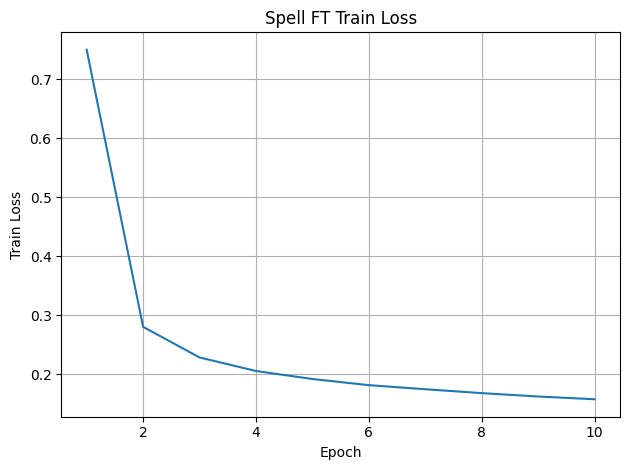

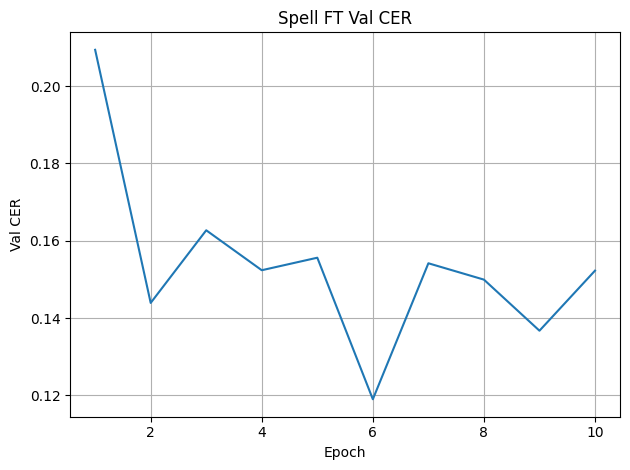


=== Inference with noise p_char=0.06 ===
CLEAN: Artificial intelligence is fun and amazing.
NOISY: rtiriial intdllisgecne is fun and afazing.
PRED : tritial intelligence is fun and afazing g
------------------------------------------------------------
CLEAN: I really love this pizza.
NOISY: I realy ovoe this pizza.
PRED : i really over this pizza aza
------------------------------------------------------------
CLEAN: The quick brown fox jumps over the lazy dog.
NOISY: The quicek brown fou jumpssovr thehlazy dog.
PRED : the quicker brown fought him sovered the lazy dog g
------------------------------------------------------------
CLEAN: This model should correct common typos reliably.
NOISY: This model should cprrectgucommon typos relaiably.
PRED : this model should correct common typos relatively you
------------------------------------------------------------

=== Inference with noise p_char=0.1 ===
CLEAN: Artificial intelligence is fun and amazing.
NOISY: rtiriial intdlsignece is u

In [ ]:
# Plots
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

dfsp = pd.read_csv(LOG_SP)

plt.figure()
plt.plot(dfsp["epoch"], dfsp["train_loss"])
plt.xlabel("Epoch"); plt.ylabel("Train Loss"); plt.title("Spell FT Train Loss")
plt.grid(True); plt.tight_layout()
plot_train_sp = os.path.join(SAVE_DIR_SPELL, "plot_train_loss.png")
plt.savefig(plot_train_sp, dpi=160)
plt.show()


plt.figure()
plt.plot(dfsp["epoch"], dfsp["val_cer"])
plt.xlabel("Epoch"); plt.ylabel("Val CER"); plt.title("Spell FT Val CER")
plt.grid(True); plt.tight_layout()
plot_val_sp = os.path.join(SAVE_DIR_SPELL, "plot_val_cer.png")
plt.savefig(plot_val_sp, dpi=160)
plt.show()

# Noisy inference demo
@torch.no_grad()
def load_spell_for_infer():
    m = CharDecoderLM(vocab_size=VOCAB_SIZE_SP, d_model=D_MODEL_SPELL, n_heads=N_HEADS_SPELL,
                      n_layers=N_LAYERS_SPELL, max_len=MAX_LEN_SPELL, dropout=DROPOUT_SPELL).to(device)
    state = torch.load(BEST_SPELL if os.path.exists(BEST_SPELL) else ckpt_spell, map_location=device)
    m.load_state_dict(state, strict=True)
    m.eval()
    return m

def make_noisy(s: str, p_char: float = 0.10, seed: int | None = 123) -> str:
    if seed is not None:
        rnd = random.getstate()
        random.seed(seed)
        try:
            return apply_noise_ops(s, p_char=p_char)
        finally:
            random.setstate(rnd)
    else:
        return apply_noise_ops(s, p_char=p_char)

spell_model = load_spell_for_infer()
samples_clean = [
    "Artificial intelligence is fun and amazing.",
    "I really love this pizza.",
    "The quick brown fox jumps over the lazy dog.",
    "This model should correct common typos reliably."
]

for p in [0.06, 0.10, 0.18]:
    print(f"\n=== Inference with noise p_char={p} ===")
    for i, clean in enumerate(samples_clean):
        noisy = make_noisy(clean, p_char=p, seed=123+i)
        # Pass the device to the generate_greedy function
        pred = generate_greedy(spell_model, noisy.lower(), stoi_spell, itos_spell, MAX_LEN_SPELL, device=device)
        print("CLEAN:", clean)
        print("NOISY:", noisy)
        print("PRED :", pred)
        print("-"*60)

print("Saved plots:", plot_train_sp, "|", plot_val_sp)


# Part B — IMDb Sentiment Fine-tune (Binary) [Implementation - 100 Marks]

### 🎬 **Fine-Tuning a Character-Level Sentiment Classifier**

In this section, you’ll dive into the art of **fine-tuning a Transformer model** for sentiment analysis — but with a twist! Instead of feeding the model words or tokens, you’ll be working *character by character*, teaching it to sense sentiment through raw text patterns. You’ll use the IMDb movie reviews dataset, wrap it up in a PyTorch `Dataset`, and train a classification head on top of a pre-trained `CharDecoderLM`. By the end, you’ll have a model that can tell if a review sounds *happy* or *horrified* — one letter at a time.


### 💡 Assignment Component: Character-Level Sentiment Classifier (IMDb)

In this part of the assignment, you’ll build and fine-tune a **character-level sentiment classifier** using a pre-trained Transformer-based language model (`CharDecoderLM`). The goal is to classify IMDb movie reviews as *positive* or *negative*, all while practicing fine-tuning techniques and dataset handling in PyTorch.

---

### 🧩 What’s Going On in the Code

1. **Dataset Setup:**

   * We load the **IMDb dataset** using 🤗 `datasets` library’s `load_dataset()` function.
   * Each review is encoded *character by character* using the provided vocabulary mapping (`stoi_sent`).
   * Padding (`<PAD>`), sequence start (`<BOS>`), end (`<EOS>`), and separator (`<SEP>`) tokens are handled carefully to make sure inputs align properly.
   * The data is wrapped in a `torch.utils.data.Dataset` class (`IMDbCharDataset`) and fed to PyTorch `DataLoader`s for efficient batching.

2. **Model Architecture:**

   * The base model (`CharDecoderLM`) acts as a **character-level encoder**.
   * On top of it, a lightweight classification **head** (`SentimentClassifier`) is added — basically a few `nn.Linear`, `nn.Dropout`, and `nn.GELU` layers ending with a single output neuron (since it’s binary classification).

3. **Fine-Tuning:**

   * Some of the lower Transformer layers can be *frozen* to preserve pre-trained knowledge (`FREEZE_BOTTOM` flag).
   * The optimizer (`AdamW`) uses different learning rates for the base and head to make training more stable.
   * Training uses **BCEWithLogitsLoss**, and metrics such as **accuracy** and **F1 score** are computed every epoch.
   * A model checkpoint is saved whenever validation accuracy improves.

4. **Evaluation & Visualization:**

   * After training, accuracy and loss curves are plotted and saved using `matplotlib`.
   * ROC curve and AUROC score are computed from prediction probabilities to assess the classifier’s discrimination ability.
   * All results (metrics, plots, ROC points) are saved neatly to disk for your final report.

---

### 🧰 Libraries and Methods You’ll Need to Import

Make sure you have all of these handy:

```python
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import torch, torch.nn as nn
import torch.optim
from tqdm import tqdm
import numpy as np, pandas as pd, json, csv, os
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
```

…and of course, the custom components provided for you:

* `CharDecoderLM` – the base character-level Transformer model.
* `stoi_sent` – dictionary for converting characters to token IDs.
* Configuration variables like `cfg_sent`, `BASE_DIR_SENT`, and `ckpt_sent`.

---

### 🧠 What You’re Expected to Do

Students are expected to:

* Implement or complete sections related to **encoding**, **training loop**, or **evaluation** as specified.
* Understand how **character-level representations** differ from word-level embeddings.
* Interpret model performance using **accuracy, F1, and AUROC**.
* Explain why freezing layers or adjusting learning rates can affect fine-tuning performance.

---

### 🌟 Pro Tip

Even though this is character-level modeling (yes, we’re literally feeding the model *letters*), the same fine-tuning logic applies as in larger NLP systems like BERT or GPT. The difference? Here, you’re teaching the model to “feel” sentiment one character at a time — pretty cool, right?

---

Perfect 😄 — here’s a **concise “requirements checklist”** version you can drop right after the main description. It’s short, practical, and student-friendly:

---

### ✅ **Requirements Checklist**

Before running your code, make sure you’ve got everything covered:

#### 🔧 **Imports**

* Core libraries:

  ```python
  import os, json, csv, torch, numpy as np, pandas as pd
  import torch.nn as nn
  from torch.utils.data import Dataset, DataLoader
  from tqdm import tqdm
  import matplotlib
  matplotlib.use("Agg")
  import matplotlib.pyplot as plt
  ```
* External dataset loader:

  ```python
  from datasets import load_dataset
  ```
* Predefined components (provided in the assignment setup):

  ```python
  from your_model_file import CharDecoderLM, stoi_sent, cfg_sent, BASE_DIR_SENT, ckpt_sent
  ```

#### 🧩 **Model Components**

* Define or use:

  * `encode_text()` – converts raw text → token IDs (character-level)
  * `IMDbCharDataset` – wraps IMDb data for PyTorch
  * `collate_simple()` – combines samples into batches
  * `SentimentClassifier` – classifier head on top of `CharDecoderLM`

#### ⚙️ **Training Setup**

* Create dataloaders:

  ```python
  train_loader_se = DataLoader(train_ds_se, batch_size=64, shuffle=True, collate_fn=collate_simple)
  test_loader_se  = DataLoader(test_ds_se,  batch_size=64, shuffle=False, collate_fn=collate_simple)
  ```
* Initialize model + optimizer:

  ```python
  model_se = SentimentClassifier(base_se)
  optimizer_se = torch.optim.AdamW(...)
  bce = nn.BCEWithLogitsLoss()
  ```
* Include gradient scaling (`torch.amp.GradScaler`) for GPU efficiency.

#### 📊 **Metrics & Saving**

* Track and plot:

  * **Loss** (`train_loss`, `val_loss`)
  * **Accuracy**
  * **F1-score**
  * **ROC / AUROC**
* Save:

  * Model checkpoint (`best_senti.pt`)
  * Curves (`acc_curve.png`, `loss_curve.png`, `roc_curve.png`)
  * Metrics (`metrics.csv`, `history.json`)

#### 🧠 **Concepts to Understand**

* Why we use **BCEWithLogitsLoss** for binary classification
* The role of **freezing lower Transformer layers**
* How **autocast + GradScaler** speed up mixed-precision training
* How **ROC curves** show model discrimination ability

---

**Goal**: Classify reviews as positive/negative.  
**Backbone**: same pretrained encoder; we add an MLP head and pool the hidden state at `[SEP]` (fallback to last token).  
**Metrics**: Accuracy, F1, **ROC & AUROC**.



### B.1 Dataset and Encoding
We encode text as characters with `[BOS] ... [SEP]` and pad to `MAX_LEN`. The `[SEP]` index is used to pool hidden states.


This chunk of code is all about **getting your IMDB data ready for a character-level sentiment model**. Here’s the scoop:

1. **Imports you need**:

   * `load_dataset` from `datasets` (to grab the IMDB data).
   * `Dataset` and `DataLoader` from `torch.utils.data` (to wrap your data and make batches).
   * `torch` for tensors.

2. **Key constants**:

   * `PAD_ID_SE`, `BOS_ID_SE`, `EOS_ID_SE`, `SEP_ID_SE` – special token IDs for padding, beginning, end, and separator.
   * `MAX_LEN_SE` – max sequence length for your text.
   * `D_MODEL_SE`, `N_HEADS_SE`, `N_LAYERS_SE`, `DROPOUT_SE` – standard model hyperparameters.
   * `VOCAB_SIZE_SE` – size of your character-level vocabulary.

3. **The `encode_text` function**:

   * Turns a string into a list of integer IDs for each character.
   * Adds `<BOS>` at the start, `<SEP>` at the end, and pads with `<PAD>` if the sequence is shorter than `max_len`.
   * Returns the padded ID list **and** the index of the `<SEP>` token.

4. **Custom `IMDbCharDataset` class**:

   * Wraps the IMDB dataset in a PyTorch-friendly format.
   * Stores `texts` and `labels`.
   * `__getitem__` returns a tuple of `(ids, sep_idx, label)` as tensors.

5. **`collate_simple` function**:

   * Packs a batch of `(ids, sep_idx, label)` into tensors so your DataLoader can hand them off neatly.

6. **Quick toggle option (`QUICK_RUN_SENT`)**:

   * Lets you limit dataset size for fast CPU testing.

7. **DataLoaders**:

   * `train_loader_se` and `test_loader_se` handle batching, shuffling, and pinning memory for GPU (optional).

So basically, **this snippet is the pipeline from raw IMDB reviews → character IDs → ready-to-batch PyTorch tensors**, making your life much easier when you start building your model.



In [ ]:
# CELL B1: IMDb dataset (char-level) -> encode_text, dataset, collate
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import torch

SAVE_DIR_SENT="/content/checkpoints_IMDB"
# CONFIG for sentiment part (tweak if needed)
MAX_LEN_SE = min(cfg_sent.get("max_len", CFG.max_len), 256)
BATCH_SE   = min(cfg_sent.get("batch_size", CFG.batch_size), 64)
os.makedirs(SAVE_DIR_SENT, exist_ok=True)
SAVE_SENT_BEST = os.path.join(SAVE_DIR_SENT, "best_senti.pt")

# helper: encode a single text to ids, return ids and sep_idx
def encode_text(text: str, stoi: Dict[str,int], max_len: int):
    BOS = stoi['<BOS>']; SEP = stoi['<SEP>']; EOS = stoi['<EOS>']; PAD = stoi['<PAD>']
    text = text.strip()
    ids = [BOS]
    for ch in text.lower():
        ids.append(stoi.get(ch, PAD))
    ids.append(SEP)
    # pad or truncate so that sep index is known
    if len(ids) >= max_len:
        # make sure sep is inside; if not, cut earlier and set sep at last valid pos
        ids = ids[:max_len-1]  # leave space for EOS maybe
        if ids[-1] != SEP:
            ids[-1] = SEP
    # append EOS token (optional), then pad
    ids.append(EOS)
    pad_len = max_len - len(ids)
    if pad_len > 0:
        ids = ids + [PAD]*pad_len
    sep_idx = ids.index(SEP) if SEP in ids else max_len-1
    return ids, sep_idx

class IMDbCharDataset(Dataset):
    def __init__(self, split="train", max_len=MAX_LEN_SE, stoi=None, quick_run=None):
        ds = load_dataset("imdb", split=split)
        self.max_len = max_len
        self.stoi = stoi
        self.texts = ds["text"]
        self.labels = ds["label"]
        if quick_run:
            self.texts = self.texts[:quick_run]
            self.labels = self.labels[:quick_run]

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        txt = self.texts[idx]
        lbl = int(self.labels[idx])
        ids, sep = encode_text(txt, self.stoi, self.max_len)
        return torch.LongTensor(ids), torch.LongTensor([sep]), torch.tensor(lbl, dtype=torch.float32)

def collate_simple(batch):
    # batch: list of (ids_tensor, sep_tensor, label_tensor)
    ids = torch.stack([b[0] for b in batch], dim=0)
    seps = torch.cat([b[1] for b in batch], dim=0)  # shape (B,)
    ys = torch.stack([b[2] for b in batch], dim=0)
    return ids, seps, ys


### B.2 Classifier Head and Freezing Policy

**What this code does (and what you need to pay attention to):**

This snippet builds a **character-level sentiment classifier** on top of a pre-trained `CharDecoderLM`. The idea is: we take the hidden representations from the decoder and throw them through a small feed-forward head to get a sentiment score (single number, because we’re using `BCEWithLogitsLoss`).

**Key pieces for you to notice:**

1. **Imports & libraries:**

   * `torch` and `torch.nn as nn` are essential.
   * You should have `CharDecoderLM` defined somewhere (or imported), since that’s the backbone.

2. **The `SentimentClassifier` class:**

   * `__init__` takes the base model (`CharDecoderLM`) and builds a small head: `Dropout → Linear → GELU → Dropout → Linear`.
   * `forward` can either pool the last token or pick out the hidden state at `sep_positions` (your choice, depending on dataset formatting).

3. **Model building:**

   * Instantiate your base `CharDecoderLM` with the usual hyperparameters (`vocab_size`, `d_model`, `n_heads`, `n_layers`, `max_len`, `dropout`).
   * Load weights with `load_state_dict`. Pay attention to `missing` and `unexpected` keys—they’re fine as long as you know which parts aren’t loaded.

4. **Optional freezing:**

   * You can freeze the bottom layers to keep them from updating during training (here controlled by `FREEZE_BOTTOM`).

**Tips for students:**

* Make sure all your imports are in place: `torch`, `torch.nn`, and the class `CharDecoderLM`.
* Remember that the classifier head outputs a **single logit per example**, so use `BCEWithLogitsLoss` during training.
* The `gather` trick is just fancy indexing to grab the hidden state at a specific token (`<SEP>`).



<!-- We pool hidden states at `[SEP]` (or last token) and pass through a 2-layer MLP head. Optionally freeze bottom layers for stability. -->


In [ ]:
import torch.nn as nn

class SentimentClassifier(nn.Module):
    def __init__(self, base_model: CharDecoderLM, d_model:int, dropout:float=0.1, freeze_bottom:bool=False, freeze_n:int=0):
        super().__init__()
        self.base = base_model
        self.pool_proj = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model//2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, 1)  # single logit
        )
        if freeze_bottom:
            # freeze first freeze_n transformer layers (if provided)
            for name, p in self.base.named_parameters():
                p.requires_grad = True  # default
            # try to freeze encoder.layers[:freeze_n] by name convention
            for n, layer in enumerate(self.base.transformer.layers):
                if n < freeze_n:
                    for p in layer.parameters():
                        p.requires_grad = False

    def forward(self, ids, sep_idx):
        # ids: (B, T), sep_idx: (B,) int tensor
        # get hidden states from base
        hs = self.base.forward_hidden(ids)  # (B, T, d_model)
        B, T, D = hs.shape
        # gather hidden at sep positions
        # sep_idx is tensor (B,)
        sep_idx = sep_idx.long().to(hs.device)
        # index
        h_sep = hs[torch.arange(B, device=hs.device), sep_idx, :]  # (B, D)
        logits = self.pool_proj(h_sep).squeeze(-1)  # (B,)
        return logits

# Instantiate base and classifier
VOCAB_SIZE_SE = len(stoi_sent)
D_MODEL_SE = cfg_sent.get("d_model", CFG.d_model)
N_HEADS_SE = cfg_sent.get("n_heads", CFG.n_heads)
N_LAYERS_SE = cfg_sent.get("n_layers", CFG.n_layers)
MAX_LEN_SE = min(cfg_sent.get("max_len", CFG.max_len), MAX_LEN_SE)

base_se = CharDecoderLM(vocab_size=VOCAB_SIZE_SE, d_model=D_MODEL_SE,
                        n_heads=N_HEADS_SE, n_layers=N_LAYERS_SE,
                        max_len=MAX_LEN_SE, dropout=cfg_sent.get("dropout", CFG.dropout)).to(device)

# load pretrained weights (be permissive)
state = torch.load(ckpt_sent, map_location=device)
if isinstance(state, dict) and "model_state_dict" in state:
    base_se.load_state_dict(state["model_state_dict"], strict=False)
else:
    try:
        base_se.load_state_dict(state, strict=False)
    except Exception:
        if "state_dict" in state:
            base_se.load_state_dict(state["state_dict"], strict=False)

# build classifier
FREEZE_BOTTOM = False
FREEZE_N = 0
model_se = SentimentClassifier(base_se, d_model=D_MODEL_SE, dropout=cfg_sent.get("dropout",0.1),
                              freeze_bottom=FREEZE_BOTTOM, freeze_n=FREEZE_N).to(device)



### B.3 Train/Eval + ROC


This snippet shows how to **fine-tune a character-level sentiment classifier** on IMDb data. Your task will be to implement something similar from scratch, so here’s what’s happening:

1. **Imports & Setup**

   * Make sure to import:

     ```python
     import torch, torch.nn as nn
     from tqdm import tqdm
     import os, csv
     ```
   * You’ll also need `torch.amp.GradScaler` if you’re using mixed precision (faster training on GPU) and an optimizer (`AdamW`).

2. **Optimizer & Loss**

   * Two learning rates: one for the base model and one for the classifier head (`head.` parameters).
   * Loss is **binary cross-entropy with logits** (`nn.BCEWithLogitsLoss()`).

3. **Checkpointing & History Tracking**

   * Creates a folder to save the **best model** (`best_senti.pt`).
   * Tracks `train_loss`, `val_loss`, `train_acc`, `val_acc`, `train_f1`, and `val_f1` across epochs.
   * Implements a helper `_f1(tp, fp, fn)` to calculate **F1 score** from true positives, false positives, and false negatives.

4. **Training Loop**

   * For each batch:

     * Move inputs to the GPU (or CPU).
     * Compute logits and loss.
     * Backpropagate with **gradient scaling** for mixed precision.
     * Clip gradients (`clip_grad_norm_`) for stability.
     * Update running totals for **loss**, **accuracy**, and **F1**.

5. **Evaluation Loop**

   * Disable gradients (`torch.no_grad()`) for faster evaluation.
   * Compute validation loss, accuracy, and F1, just like training.

6. **Model Saving**

   * If current epoch gives better validation accuracy, save the model to `best_senti.pt`.

7. **Output**

   * After all epochs, prints the **best validation accuracy**.

💡 **Hints for students:**

* Pay attention to **moving tensors to the right device**, **sigmoid + thresholding for predictions**, and **separate learning rates for head vs. base**.
* Use `tqdm` to keep your training loop *nice and readable*.


In [ ]:
# CELL B3: training loop for sentiment classifier
import torch, os, csv, math
from torch.optim import AdamW
from torch import amp
from tqdm import tqdm
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader

EPOCHS_SE = 10
LR_BASE = 1e-5    # for base
LR_HEAD = 1e-4    # for head
BATCH_SE = BATCH_SE

# dataloaders
train_ds_se = IMDbCharDataset(split="train", max_len=MAX_LEN_SE, stoi=stoi_sent, quick_run=None)
test_ds_se  = IMDbCharDataset(split="test",  max_len=MAX_LEN_SE, stoi=stoi_sent, quick_run=None)

train_loader_se = DataLoader(
    train_ds_se, batch_size=BATCH_SE, shuffle=True,
    collate_fn=collate_simple, num_workers=2, pin_memory=True
)
test_loader_se  = DataLoader(
    test_ds_se, batch_size=BATCH_SE, shuffle=False,
    collate_fn=collate_simple, num_workers=2, pin_memory=True
)

# different LRs for base and head
param_groups = [
    {"params": [p for n,p in model_se.base.named_parameters() if p.requires_grad], "lr": LR_BASE},
    {"params": [p for p in model_se.pool_proj.parameters()], "lr": LR_HEAD}
]
optimizer_se = AdamW(param_groups, weight_decay=cfg_sent.get("weight_decay", CFG.weight_decay))

# ✅ updated GradScaler
scaler_se = amp.GradScaler(device="cuda", enabled=(device == 'cuda'))
bce = nn.BCEWithLogitsLoss()

# history
history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[], "train_f1":[], "val_f1":[]}

def _f1(tp, fp, fn):
    p = tp/(tp+fp+1e-12)
    r = tp/(tp+fn+1e-12)
    return 2*p*r/(p+r+1e-12)

best_val_acc = 0.0

for epoch in range(1, EPOCHS_SE+1):
    # TRAIN
    model_se.train()
    running_loss = 0.0; n_samples = 0
    tp = fp = fn = 0
    pbar = tqdm(train_loader_se, desc=f"Train E{epoch}")
    for ids, seps, ys in pbar:
        ids = ids.to(device); seps = seps.to(device); ys = ys.to(device)
        optimizer_se.zero_grad()
        with amp.autocast(device_type="cuda", enabled=(device == 'cuda')):
            logits = model_se(ids, seps)  # (B,)
            loss = bce(logits, ys)
        scaler_se.scale(loss).backward()
        scaler_se.unscale_(optimizer_se)
        torch.nn.utils.clip_grad_norm_(model_se.parameters(), cfg_sent.get("grad_clip", CFG.grad_clip))
        scaler_se.step(optimizer_se); scaler_se.update()
        running_loss += loss.item() * ids.size(0); n_samples += ids.size(0)
        # metrics
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        labels = ys.detach().cpu().numpy().astype(int)
        tp += int(((preds==1) & (labels==1)).sum())
        fp += int(((preds==1) & (labels==0)).sum())
        fn += int(((preds==0) & (labels==1)).sum())
        pbar.set_postfix({"loss": running_loss / n_samples})
    train_loss = running_loss / n_samples
    tn = n_samples - tp - fp - fn
    train_acc = (tp + tn) / n_samples
    train_f1 = _f1(tp, fp, fn)

    # VALIDATION
    model_se.eval()
    v_loss = 0.0; v_n = 0
    v_tp = v_fp = v_fn = 0
    with torch.no_grad():
        for ids, seps, ys in tqdm(test_loader_se, desc="Val"):
            ids = ids.to(device); seps = seps.to(device); ys = ys.to(device)
            logits = model_se(ids, seps)
            loss = bce(logits, ys)
            v_loss += loss.item() * ids.size(0); v_n += ids.size(0)
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            labels = ys.detach().cpu().numpy().astype(int)
            v_tp += int(((preds==1) & (labels==1)).sum())
            v_fp += int(((preds==1) & (labels==0)).sum())
            v_fn += int(((preds==0) & (labels==1)).sum())
    val_loss = v_loss / v_n
    tn = v_n - v_tp - v_fp - v_fn
    val_acc = (v_tp + tn) / v_n
    val_f1 = _f1(v_tp, v_fp, v_fn)

    # logging
    history["train_loss"].append(train_loss); history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc); history["val_acc"].append(val_acc)
    history["train_f1"].append(train_f1); history["val_f1"].append(val_f1)
    print(f"Epoch {epoch}: tr_loss={train_loss:.4f} val_loss={val_loss:.4f} tr_acc={train_acc:.4f} val_acc={val_acc:.4f} val_f1={val_f1:.4f}")

    # save on best val_acc
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_se.state_dict(), SAVE_SENT_BEST)

# final save
torch.save(model_se.state_dict(), os.path.join(SAVE_DIR_SENT, "last_senti.pt"))
print("Training done. Best val acc:", best_val_acc)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Val: 100%|██████████| 391/391 [01:48<00:00,  3.60it/s]


Epoch 1: tr_loss=0.6906 val_loss=0.6779 tr_acc=0.5299 val_acc=0.5742 val_f1=0.5986


Val: 100%|██████████| 391/391 [01:52<00:00,  3.47it/s]


Epoch 2: tr_loss=0.6528 val_loss=0.6078 tr_acc=0.6095 val_acc=0.6636 val_f1=0.6747


Val: 100%|██████████| 391/391 [01:52<00:00,  3.48it/s]


Epoch 3: tr_loss=0.5889 val_loss=0.5740 tr_acc=0.6812 val_acc=0.6912 val_f1=0.6634


Val: 100%|██████████| 391/391 [01:52<00:00,  3.48it/s]


Epoch 4: tr_loss=0.5429 val_loss=0.5451 tr_acc=0.7189 val_acc=0.7160 val_f1=0.7148


Val: 100%|██████████| 391/391 [01:52<00:00,  3.48it/s]


Epoch 5: tr_loss=0.5107 val_loss=0.5487 tr_acc=0.7432 val_acc=0.7207 val_f1=0.7003


Val: 100%|██████████| 391/391 [01:52<00:00,  3.47it/s]


Epoch 6: tr_loss=0.4848 val_loss=0.5347 tr_acc=0.7610 val_acc=0.7283 val_f1=0.7226


Val: 100%|██████████| 391/391 [01:52<00:00,  3.48it/s]


Epoch 7: tr_loss=0.4606 val_loss=0.5752 tr_acc=0.7795 val_acc=0.7189 val_f1=0.6857


Val: 100%|██████████| 391/391 [01:52<00:00,  3.47it/s]


Epoch 8: tr_loss=0.4443 val_loss=0.5767 tr_acc=0.7892 val_acc=0.7279 val_f1=0.7056


Val: 100%|██████████| 391/391 [01:52<00:00,  3.47it/s]


Epoch 9: tr_loss=0.4212 val_loss=0.5976 tr_acc=0.8034 val_acc=0.7288 val_f1=0.7040


Val: 100%|██████████| 391/391 [01:52<00:00,  3.48it/s]


Epoch 10: tr_loss=0.3945 val_loss=0.6105 tr_acc=0.8207 val_acc=0.7332 val_f1=0.7301
Training done. Best val acc: 0.73316



### B.4 Curves, ROC and AUC

This snippet is the "reporting & evaluation" tail of a training run. It:
- draws and saves accuracy and loss curves (train vs val),
- writes epoch-wise metrics to a CSV and dumps the full history to JSON,
- loads the best model state, collects prediction probabilities on the test set,
- computes and plots an ROC curve (and saves the ROC points to CSV),
- prints summary paths and the AUROC.

Below I list exactly what you must import, the global variables / objects this snippet expects, and the required shapes/types/formats for those objects so the snippet will run without surprises.

---

## Required imports (copy-paste friendly)
Make sure you import these before running the snippet:

```python
import os
import json
import csv
import numpy as np
import pandas as pd            # used at top of your original snippet (not strictly needed by the shown code, but kept for consistency)
import matplotlib
matplotlib.use("Agg")        # non-interactive backend for saving figures in headless environments
import matplotlib.pyplot as plt

import torch                   # for model, torch.no_grad, torch.sigmoid, torch.load, device movement
# and any other PyTorch utilities you normally use (e.g., torch.nn, torch.optim) elsewhere in the project
```

---

## Globals / variables the snippet expects to exist
The snippet uses these names; make sure you define them in your training script or environment before running:

```python
SAVE_DIR_SENT      # str: directory path where all saved artifacts will go (plots, CSV, JSON)
SAVE_SENT_BEST     # str: path to the saved best model state dict (the file you load with torch.load)
device             # torch.device: e.g., torch.device("cuda") or torch.device("cpu")
model_se           # torch.nn.Module: the model instance whose state_dict will be loaded
test_loader_se     # DataLoader: yields batches from the test set
history            # dict: training history with keys listed below
```

Expected `history` keys (each a list of length num_epochs):
- "train_loss", "val_loss"         -> lists/arrays of floats
- "train_acc",  "val_acc"          -> lists/arrays of floats in [0,1] or percentages (consistent)
- "train_f1",   "val_f1"           -> lists/arrays of floats (optional for plotting, but snippet writes them)

Example minimal structure:

```python
history = {
    "train_loss": [0.69, 0.45, ...],
    "val_loss":   [0.70, 0.47, ...],
    "train_acc":  [0.50, 0.72, ...],
    "val_acc":    [0.49, 0.70, ...],
    "train_f1":   [0.50, 0.71, ...],
    "val_f1":     [0.49, 0.70, ...],
}
```

---

## DataLoader / model contract used by ROC utilities
The ROC utilities expect:
- `test_loader_se` yields tuples of the form `(ids, sep, y)` per batch.
  - `ids` and `sep` are tensors appropriate as the model's inputs (moved to `device`).
  - `y` is a 1-D numpy array or tensor of integer labels (0/1 binary).
- `model_se(ids, sep)` returns raw logits (not probabilities) as a 1-D or 2-D tensor compatible with `torch.sigmoid`.
  - For binary classification using BCE-with-logits style, the logits tensor should be shape (batch,) or (batch, 1). The snippet uses `torch.sigmoid(logits)` to get probabilities.

Minimal example of a model call signature:

```python
# inside your model class:
def forward(self, ids, sep):
    # ids, sep: torch.LongTensor
    # returns: logits (torch.FloatTensor) shaped (batch,) or (batch, 1)
    ...
```

---

## Functions in the snippet — what they do

1. collect_probs_and_labels(dloader, model)
```python
@torch.no_grad()
def collect_probs_and_labels(dloader, model):
    model.eval()
    all_p = []
    all_y = []
    for ids, sep, y in dloader:
        ids = ids.to(device); sep = sep.to(device)
        logits = model(ids, sep)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        labels = y.numpy()
        all_p.append(probs)
        all_y.append(labels)
    return np.concatenate(all_p), np.concatenate(all_y).astype(int)
```
- Collects prediction probabilities (after sigmoid) and integer labels across the dataset.
- Returns (probs, labels) as numpy arrays suitable for ROC computation.

2. compute_roc(probs: np.ndarray, labels: np.ndarray)
```python
def compute_roc(probs: np.ndarray, labels: np.ndarray):
    probs = np.asarray(probs)
    labels = np.asarray(labels).astype(int)
    thr = np.r_[np.inf, np.unique(probs)[::-1], -np.inf]
    P = labels.sum()
    N = len(labels) - P
    tpr = []
    fpr = []
    for t in thr:
        preds = (probs >= t).astype(int)
        TP = (preds & labels).sum()
        FP = (preds & (1 - labels)).sum()
        tpr.append( TP / P if P > 0 else 0.0 )
        fpr.append( FP / N if N > 0 else 0.0 )
    tpr = np.asarray(tpr); fpr = np.asarray(fpr); thr = thr[order]
    auroc = float(np.trapz(tpr, fpr))
    return fpr, tpr, thr, auroc
```
- Computes TPR/FPR at thresholds derived from unique probability values, sorts by FPR, and calculates AUROC via trapezoidal integration.
- Note: ensures label array uses integers 0/1 and handles P=0 or N=0 edge cases gracefully.

---

## Files produced
- acc_curve.png         -> train/val accuracy curve
- loss_curve.png        -> train/val loss curve
- metrics.csv           -> rows: epoch, train_loss, val_loss, train_acc, val_acc, train_f1, val_f1
- history.json          -> exact JSON dump of the `history` dict
- roc_curve.png         -> ROC curve for the best model (loaded from SAVE_SENT_BEST)
- roc_points.csv        -> CSV of (threshold, fpr, tpr) used to draw the ROC

Make sure `SAVE_DIR_SENT` exists (os.makedirs(SAVE_DIR_SENT, exist_ok=True)) before saving.

---

## Small gotchas and tips
- matplotlib.use("Agg") is required on headless servers (CI, remote machines) so savefig works without a display.
- Ensure the shape of `probs` from model is flattened to 1-D before passing to compute_roc (the snippet concatenates whatever torch.sigmoid returns — if it's shape (batch,1), numpy will produce shape (batch,1) and concatenation still works but downstream expectations assume 1-D).
- If labels are torch tensors, convert them to `.cpu().numpy()` (the snippet assumes `y` already allows `.numpy()`; if `y` is a CUDA tensor, use `y.cpu().numpy()`).
- The snippet uses string formatting to 6 or 8 decimals for CSVs; adjust if you need more precision.

<!-- We save Accuracy/Loss curves and compute ROC & AUROC on the test split. -->


In [ ]:
SAVE_SENT_BEST="/content/checkpoints_IMDB/best_senti.pt"

In [ ]:
last_state = torch.load(os.path.join(SAVE_DIR_SENT, "last_senti.pt"), map_location=device)
model_se.load_state_dict(last_state)
model_se.eval()

IndexError: pop from empty list

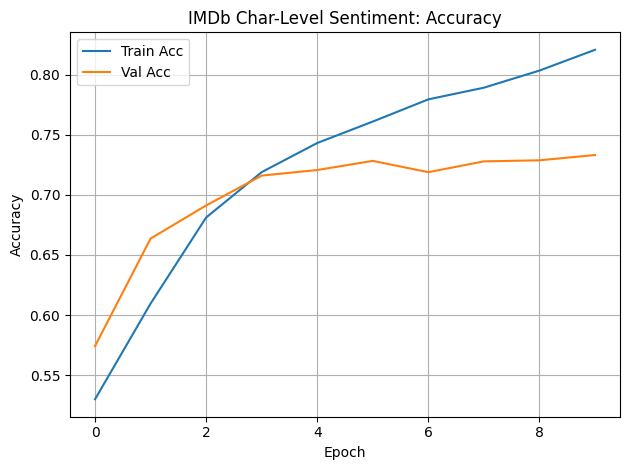

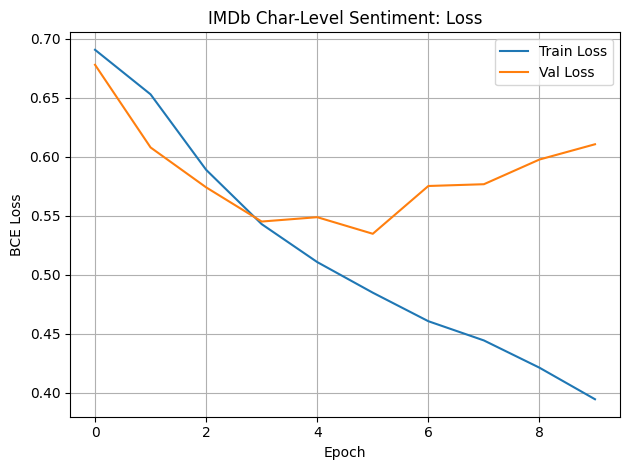

Saved: /content/checkpoints_IMDB/acc_curve.png, /content/checkpoints_IMDB/loss_curve.png, /content/checkpoints_IMDB/roc_curve.png, /content/checkpoints_IMDB/metrics.csv
AUROC=0.8166


In [ ]:
# ROC utilities
@torch.no_grad()
def collect_probs_and_labels(dloader, model):
    model.eval()
    all_p = []
    all_y = []
    for ids, seps, ys in dloader:
        ids = ids.to(device); seps = seps.to(device)
        logits = model(ids, seps)
        probs = torch.sigmoid(logits).detach().cpu().numpy().ravel()
        labels = ys.detach().cpu().numpy().astype(int)
        all_p.append(probs); all_y.append(labels)
    return np.concatenate(all_p), np.concatenate(all_y).astype(int)

def compute_roc(probs: np.ndarray, labels: np.ndarray):
    probs = np.asarray(probs)
    labels = np.asarray(labels).astype(int)
    thr = np.r_[np.inf, np.unique(probs)[::-1], -np.inf]
    P = labels.sum()
    N = len(labels) - P
    tpr = []; fpr = []
    for t in thr:
        preds = (probs >= t).astype(int)
        TP = int(((preds==1) & (labels==1)).sum())
        FP = int(((preds==1) & (labels==0)).sum())
        tpr.append( TP / P if P > 0 else 0.0 )
        fpr.append( FP / N if N > 0 else 0.0 )
    tpr = np.asarray(tpr); fpr = np.asarray(fpr)
    # sort by fpr ascending
    order = np.argsort(fpr)
    fpr = fpr[order]; tpr = tpr[order]; thr = thr[order]
    auroc = float(np.trapezoid(tpr, fpr))
    return fpr, tpr, thr, auroc


%matplotlib inline
import pandas as pd
import matplotlib
# matplotlib.use("Agg")
import matplotlib.pyplot as plt
import numpy as np
import csv

# Save curves
acc_path = os.path.join(SAVE_DIR_SENT, "acc_curve.png")
loss_path = os.path.join(SAVE_DIR_SENT, "loss_curve.png")

plt.figure()
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"],   label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("IMDb Char-Level Sentiment: Accuracy")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(acc_path, dpi=160)
plt.show()

plt.figure()
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"],   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("BCE Loss")
plt.title("IMDb Char-Level Sentiment: Loss")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(loss_path, dpi=160)
plt.show()

# Save metrics CSV/JSON
csv_path = os.path.join(SAVE_DIR_SENT, "metrics.csv")
with open(csv_path, "w", newline="") as f:
    wr = csv.writer(f)
    wr.writerow(["epoch","train_loss","val_loss","train_acc","val_acc","train_f1","val_f1"])
    for i in range(len(history["train_loss"])):
        wr.writerow([
            i+1,
            f"{history['train_loss'][i]:.6f}",
            f"{history['val_loss'][i]:.6f}",
            f"{history['train_acc'][i]:.6f}",
            f"{history['val_acc'][i]:.6f}",
            f"{history['train_f1'][i]:.6f}",
            f"{history['val_f1'][i]:.6f}",
        ])

with open(os.path.join(SAVE_DIR_SENT, "history.csv"), "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=history.keys())
    writer.writeheader()
    for i in range(len(next(iter(history.values())))):  # number of epochs
        row = {k: history[k][i] for k in history}
        writer.writerow(row)


# Load best and evaluate ROC
best_state = torch.load(SAVE_SENT_BEST, map_location=device)
model_se.load_state_dict(best_state)
model_se.eval()

probs_test, labels_test = collect_probs_and_labels(test_loader_se, model_se)
fpr, tpr, thr, auroc = compute_roc(probs_test, labels_test)

roc_path = os.path.join(SAVE_DIR_SENT, "roc_curve.png")

plt.figure()
plt.plot(fpr, tpr, label=f"AUROC = {auroc:.4f}")
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("IMDb Char-Level Sentiment: ROC (Best Model)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(roc_path, dpi=160)
plt.show()

roc_csv_path = os.path.join(SAVE_DIR_SENT, "roc_points.csv")
with open(roc_csv_path, "w", newline="") as f:
    wr = csv.writer(f); wr.writerow(["threshold","fpr","tpr"])
    for th, fp, tp in zip(thr, fpr, tpr):
        wr.writerow([f"{th:.8f}", f"{fp:.8f}", f"{tp:.8f}"])

print(f"Saved: {acc_path}, {loss_path}, {roc_path}, {csv_path}")
print(f"AUROC={auroc:.4f}")

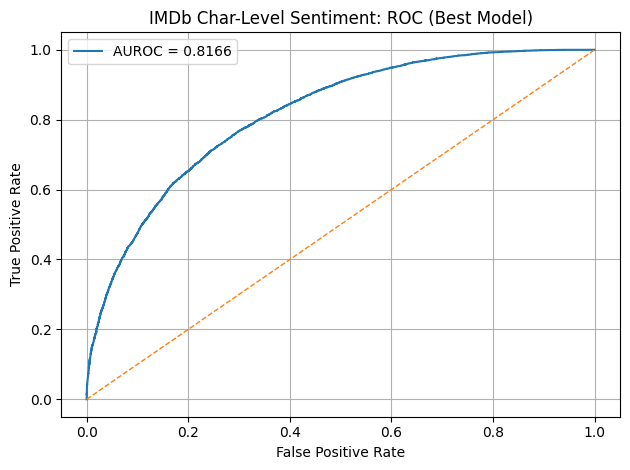

In [ ]:

plt.figure()
plt.plot(fpr, tpr, label=f"AUROC = {auroc:.4f}")
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("IMDb Char-Level Sentiment: ROC (Best Model)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(roc_path, dpi=160)
plt.show()


## Appendix: Metric Details
- **CE/PPL**: Lower is better; PPL exponential in CE. Useful to track LM quality.
- **Levenshtein/CER**: CER reflects character-level correction quality: near 0.0 is excellent.
- **Accuracy**: Exact match rate; intuitive, but can hide class imbalance.
- **Precision/Recall/F1**: F1 balances precision and recall; useful when false positives/negatives have different costs.
- **ROC/AUROC**: Threshold-free view of separability; AUROC summarizes performance across all thresholds.


## 🧩 Challenges and Observations for the below topics?

### 1. Data Noise and Tokenization

### 2. Training Stability

### 3. Metric Interpretation(Like CER and PPL)

### 4. Noise Injection Effect(like what will happen if more noise or less noise)
  

### 5. Transfer Learning to Sentiment Task


---



## Critical Questions ($20 \times 5 = 100$ Marks)

1.  **Vocabulary Construction and Handling Unknown Characters:** Explain the process of building the character vocabulary. How are characters not present in the training vocabulary handled during tokenization in both pretraining and downstream tasks? What are the implications of ignoring or replacing unknown characters?

The character vocabulary is built by scanning all text in the training data and collecting every unique character (like letters, digits, punctuation, and spaces). Each character gets an ID, and this forms the vocabulary used for tokenization.

If a new or unseen character appears later (not in the training vocabulary), it is replaced with a special `<UNK>` (unknown) token during tokenization. In both pretraining and downstream tasks, this ensures the model can still process the input without errors.

Replacing or ignoring unknown characters can slightly reduce accuracy, since the model loses that specific information about the character. But for most text, unseen characters are rare, so the impact is often small.

---
2.  **Causal Masking in the Transformer:** Describe the purpose of the causal mask in the Transformer encoder for the character-level causal language model. How does it ensure that the model only attends to preceding tokens? Explain the specific implementation detail in the attention mechanism that achieves this.

Causal masking makes sure that the model can only look at the characters that come before the current one, not the future ones. This is important for language modeling, where we predict the next character step by step.

In practice, the attention matrix is masked using an upper-triangular matrix filled with `-inf` values above the diagonal. When passed through the softmax, these positions become zero, so each character’s attention is limited to itself and earlier tokens only.

---
3.  **Target-Only Loss for Spell Correction:** Why is a "target-only" loss used for the spell correction task? Explain how masking the loss contributes to the model learning to map noisy sequences to clean ones. What would happen if the loss was applied to the entire sequence (noisy + clean)?

A “target-only” loss is used so the model learns to correct the misspelled part of the input, not just copy everything down. By masking the loss, we only compute errors on the clean (target) tokens, which guides the model to focus on fixing the mistakes.

If the loss were applied to the whole sequence, the model would waste effort learning to reproduce the noisy input too, making it less effective at actually correcting spelling errors/mistakes.

---
4.  **Pooling Strategy for Sentiment Classification:** The sentiment classification task pools the hidden state at the `[SEP]` token (or the last token). Explain why this pooling strategy is used. How does this aggregated representation capture the overall sentiment of the review? Discuss alternative pooling strategies and their potential advantages or disadvantages.

Pooling at the `[SEP]` or last token works because this position has already attended to all previous tokens, so its hidden state contains the full meaning of the review. This makes it a good summary for sentiment prediction.

Other options include mean pooling (averaging all token embeddings) or max pooling (taking the strongest signal). Mean pooling smooths out details but can lose emphasis on a particular context, while max pooling captures key emotions but may ignore overall context.

---
5.  **Impact of Noise Injection Rate on Spell Correction Performance:** Analyze the effect of varying the noise injection rate during the spell correction fine-tuning. How does increasing or decreasing the noise level impact the model's ability to correct errors? What are the potential trade-offs in training with very high or very low noise rates?

Increasing the noise rate makes the model see more mistakes, helping it learn to correct errors in a better way, but too much noise can confuse it and degrade learning. Low noise makes training easier but the model might not handle real-world errors in a good way. In NLP, every good thing comes with a trade-off. Here also there exists a trade-off between robustness and learning stability.

---